In [1]:
import torch
import random
import os
from torch import nn
from torch.utils.data import Dataset,DataLoader

corpus_file = '../hw2.1_corpus.txt'

In [2]:
# Load Corpus

corpus = []
with open(corpus_file, 'r', encoding='utf-8') as f:
    for row in f:
        row = row.replace('\n','')
        row = [w for w in row]
        corpus.append(row)

In [3]:
# Use list to guarantee the embedded index for each word are same everytime

words = []
words_set = set()
for ws in corpus:
    for w in ws:
        if w not in words_set:
            words_set.add(w)
            words.append(w)

In [4]:
import re

class Embedding:

    def __init__(self,words=None,dim=300):
        self.word_dict = {}
        self.word_list = []
        self.emb_dim = dim
        self.maxPOS = 55      # Maximum POS
        self.addition_words = ['<PAD>','<SOS>','<EOS>','<UNK>']
        
        for POS in range(self.maxPOS):
            self.addition_words.append(str(POS))
        
        for addition_word in self.addition_words:
            if addition_word not in words:
                self.word_dict[addition_word] = len(self.word_list)
                self.word_list.append(addition_word)
        
        for word in words:
            if word not in self.word_dict:
                self.word_dict[word] = len(self.word_list)
                self.word_list.append(word)
                
        self.vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict),dim))
        
    def to_index(self, word):
        # single word tokenize
        if word not in self.word_dict:
            return self.word_dict['<UNK>']
        
        return self.word_dict[word]
        
    def tokenize(self, words):
        # whole sentence tokenize
        return [self.to_index(w) for w in words]
    
    def to_word(self, idx):
        
        return self.word_list[idx]
        
    def unTokenize(self,ids):
        
        return [self.to_word(idx) for idx in ids]
        
    def get_vocabulary_size(self):
        return self.vectors.shape[0]
    
    def get_dim(self):
        return self.vectors.shape[1]

In [5]:
# establish embedder to tokenize
embedder = Embedding(words=words,dim=300)

PAD = embedder.to_index('<PAD>')
SOS = embedder.to_index('<SOS>')
EOS = embedder.to_index('<EOS>')

In [6]:
all_set = []
two_hint_ratio = 0.0

for former,latter in zip(corpus[:-1],corpus[1:]):
    
    n = len(latter)
    addition_tokens = []
    
    hint_word = 2 if random.random() < two_hint_ratio else 1

    selected_idice = random.sample(list(range(min(n,embedder.maxPOS))), k=min(n,hint_word))
    
    for selected_idx in selected_idice:
        
        addition_tokens.append(str(selected_idx+1))
        addition_tokens.append(latter[selected_idx])
    
    former = ['<SOS>'] + former + ['<EOS>'] + addition_tokens
    latter = ['<SOS>'] + latter + ['<EOS>']
    
    
    all_set.append((former,latter))

In [7]:
from sklearn.model_selection import train_test_split

train_set,valid_set = train_test_split(all_set,test_size=0.2,random_state=42)

print(len(all_set),len(train_set),len(valid_set))

741714 593371 148343


In [8]:
# list of turple : [(x0,y0),(x1,y1),(x2,y2),....]
all_set[5]

(['<SOS>',
  '你',
  '最',
  '想',
  '去',
  '的',
  '目',
  '的',
  '地',
  '剩',
  '多',
  '少',
  '公',
  '里',
  '<EOS>',
  '8',
  '可'],
 ['<SOS>', '累', '了', '也', '没', '关', '系', '我', '可', '以', '暂', '停', '<EOS>'])

In [9]:

class SentDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_data_len = max([len(data[0]) for data in datas])
        max_label_len = max([len(data[1]) for data in datas])
        
        batch_x = []
        batch_y = []
        len_x = []
        len_y = []
        batch_y_ = []
        
        
        for data,label in datas:
            
            len_x.append(len(data))
            len_y.append(len(label))
            
            # Tokenize
            pad_data = embedder.tokenize(data)
            pad_label = embedder.tokenize(label)
            
            # Padding data and label
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            if len(label) < max_label_len:
                pad_label.extend([PAD] * (max_label_len-len(label)))
                
                
            batch_x.append(pad_data)
            batch_y.append(pad_label)
            
            # generate y_
            focus_designate = [PAD] * len(pad_label)
            focus_designate[0] = SOS
            focus_designate[pad_label.index(EOS)] = EOS
            
            for i in range(data.index('<EOS>')+1,len(data),2):
                
                idx = int(data[i])
                focus_designate[idx] = pad_label[idx]
            
            batch_y_.append(focus_designate)
            
            
        return torch.LongTensor(batch_x), torch.LongTensor(len_x), torch.LongTensor(batch_y), len_y, torch.LongTensor(batch_y_)

In [10]:
# For Validate~~~~

dataset = SentDataset(train_set)
dataloader = DataLoader(dataset=dataset,
                        batch_size=4,
                        shuffle=True,
                        collate_fn=dataset.collate_fn,
                        num_workers=0)
for x,x_len,y,y_len,y_ in dataloader:
    print('Sentence length:',x_len,y_len,'\n')
    
    for xi,yi,y_i in zip(x,y,y_):      
        
        print(embedder.unTokenize(xi))
        print(embedder.unTokenize(yi))
        print(embedder.unTokenize(y_i),'\n')
    
    break


Sentence length: tensor([12, 17, 14, 13]) [7, 14, 11, 6] 

['<SOS>', '不', '是', '什', '么', '都', '有', '理', '由', '<EOS>', '5', '候', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '也', '该', '有', '时', '候', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '候', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 

['<SOS>', '明', '天', '我', '们', '一', '定', '都', '会', '遇', '见', '对', '的', '人', '<EOS>', '5', '其']
['<SOS>', '我', '还', '醒', '着', '其', '实', '我', '早', '该', '知', '足', '了', '<EOS>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '其', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EOS>'] 

['<SOS>', '我', '听', '见', '一', '只', '搁', '浅', '的', '蓝', '鲸', '<EOS>', '6', '大', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '炸', '裂', '发', '出', '巨', '大', '的', '声', '音', '<EOS>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '大', '<PAD>', '<PAD>', '<PAD>', '<EOS>', '<PA

In [11]:
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size):
        
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size,embedder.get_dim())
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.gru = nn.GRU(embedding_size, output_size,batch_first=True, bias=False)

    def forward(self, input_seqs, input_lengths, hidden=None):
        
        # Sort mini-batch by input_lengths
        sorted_input_lengths, indices = torch.sort(input_lengths,descending=True)
        _, desorted_indices = torch.sort(indices, descending=False)
        input_seqs = input_seqs[indices]
        
        # Encoder work
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, sorted_input_lengths.cpu().numpy(), batch_first=True)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs,batch_first=True)
        
        # Desort mini-batch
        outputs = outputs[desorted_indices]
        hidden = hidden[:,desorted_indices]
        
        return outputs, hidden

In [12]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, teacher_forcing_ratio=0.5):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim()) # Unused
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.cell = nn.GRUCell(embedder.get_dim(), hidden_size, bias=False)
        self.clf = nn.Linear(hidden_size, output_size, bias=False)
        
        if hidden_size == embedder.vectors.T.shape[0]:
            self.clf.weight = nn.Parameter(embedder.vectors)

        self.log_softmax = nn.LogSoftmax(dim=1)  # work with NLLLoss

        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward_step(self, inputs, hidden):
        
        # Unused
        embedded = self.embedding(inputs)
        # For research : all x to 0
        embedded = torch.zeros_like(embedded)
        
        hidden = self.cell(embedded, hidden) # [B,Hidden_dim]
        clf_output = self.clf(hidden) # [B,Output_dim]
        output = self.log_softmax(clf_output)

        return output, hidden

    def forward(self, context_vector, target_vars, target_lengths):

        batch_size = context_vector.shape[1]
        
        decoder_input = torch.LongTensor([SOS] * batch_size).to(device)
        decoder_hidden = context_vector.squeeze(0)

        if target_lengths is None:
            max_target_length = 50
        else:
            max_target_length = max(target_lengths)
        decoder_outputs = []
        decoder_hiddens = []

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        for t in range(max_target_length):    
            
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_outputs_on_t)
            decoder_hiddens.append(decoder_hidden)
            
            # Take input for next GRU iteration
            if use_teacher_forcing :
                decoder_input = target_vars[:,t]
            else:
                decoder_input = decoder_outputs_on_t.argmax(-1)
            
            # Early Stop when all predict <EOS> 
            if torch.all(decoder_input==EOS) and target_lengths is None and self.train() == False:
                break
            
        # Stack output of each word at dimension 2
        decoder_outputs = torch.stack(decoder_outputs,dim=2)
        # Stack hidden of each timestep at dimension 1
        decoder_hiddens = torch.stack(decoder_hiddens,dim=1)
        
        return decoder_outputs, decoder_hiddens

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input_seqs, input_lengths, target_seqs=None, target_lengths=None):
        outputs, hidden = encoder(input_seqs, input_lengths)
        outputs, hiddens = decoder(hidden, target_seqs, target_lengths)
        return outputs,hiddens

In [14]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

context_dim = 128

encoder = Encoder(embedder.get_vocabulary_size(),embedder.get_dim(),output_size=context_dim)
decoder = Decoder(context_dim,embedder.get_vocabulary_size(),0.5)
model = Seq2Seq(encoder,decoder)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6618, 300)
    (gru): GRU(300, 128, bias=False, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6618, 300)
    (cell): GRUCell(300, 128, bias=False)
    (clf): Linear(in_features=128, out_features=6618, bias=False)
    (log_softmax): LogSoftmax()
  )
)

# Training ( Dont run when analysing )

In [15]:
# def run_epoch(epoch,dataset,isTraining):
    
#     if isTraining:
#         model.train()
#     else:
#         model.eval()
        
#     dataloader = DataLoader(dataset=dataset,
#                             batch_size=32,
#                             shuffle=True,
#                             collate_fn=dataset.collate_fn,
#                             num_workers=0)
    
#     if isTraining:
#         desc='Train {}'
#     else:
#         desc='Valid {}'
    
#     trange = tqdm(enumerate(dataloader), total=len(dataloader),desc=desc.format(epoch))
    
#     loss=0
#     acc = 0
    
#     for i,(x,x_len,y,y_len,y_) in trange:
        
#         x = x.to(device)
#         y = y.to(device)
#         y_ = y_.to(device)
        
#         # outputs : [b,emb,s] , hiddens : [b,s,hidden]
#         outputs,hiddens = model(x,x_len,y,y_len)
        
#         idx = y_>2
#         tf_map = y_[idx] == outputs.argmax(1)[idx]
#         batch_acc = tf_map.sum().cpu().float().numpy()/len(tf_map)
#         acc += batch_acc
        
#         batch_loss_all = criterion(outputs, y)
#         batch_loss_designated = criterion(outputs, y_)
#         batch_loss = (1-focus_ratio)*batch_loss_all + focus_ratio*batch_loss_designated
        
#         if isTraining:
#             optimizer.zero_grad()
#             batch_loss.backward()
#             optimizer.step()
        
#         loss += batch_loss.item()
        
#         trange.set_postfix({'loss':loss/(i+1),'accuracy':acc/(i+1)})
        
#         if isTraining:
#             history_loss['train'].append(batch_loss.item())
#             history_acc['train'].append(batch_acc)
#         else:
#             history_loss['valid'].append(batch_loss.item())
#             history_acc['valid'].append(batch_acc)

In [16]:
# # Training

# dataset_all = SentDataset(all_set)
# dataset_train = SentDataset(train_set)
# dataset_valid = SentDataset(valid_set)

# criterion = torch.nn.NLLLoss(ignore_index=PAD, size_average=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# max_epoch = 20
# focus_ratio = 0.5

# history_loss = {'train':[],'valid':[]}
# history_acc = {'train':[],'valid':[]}


# for epoch in range(max_epoch):
    
#     # Training
#     run_epoch(epoch,dataset=dataset_train,isTraining=True)
    
#     # Validation
#     run_epoch(epoch,dataset=dataset_valid,isTraining=False)
    
#     # Saving
#     if not os.path.exists('model'):
#         os.makedirs('model')
#     torch.save(model.state_dict(), 'model/model.pkl.{}'.format(epoch))

# Plot (Loss and acc)  ( Dont run when analysis )

In [17]:
# import matplotlib.pyplot as plt

# modes = ['train', 'valid']
# recs = [history_loss, history_acc]
# names = ['Loss', 'Accuracy']

# values = []
# for mode in modes:
#     v = []
#     for rec in recs:
#         v.append(rec[mode])
#     values.append(v)

# plt.figure(figsize=(32, 4))
# plt.subplots_adjust(left=0.02, right=0.999)
# for r, name in enumerate(names):
#     plt.subplot(1, len(recs), r+1)
#     for m in range(len(modes)):
#         plt.plot(values[m][r])
#     plt.title(name)
#     plt.legend(modes)
#     plt.xlabel('iteration')
#     plt.show()
# #plt.savefig('figure.png', dpi=100)

## Convert models into directly-pickled format to solve cross-platform inconsistency

In [18]:
# import pickle

# path = 'pre-train/model.pkl.2-1-1'
# with open(path+'.state_dict', 'wb') as f:
#     pickle.dump(model.cpu().state_dict(), f)

# Inference Test Data

## Define test data dataloader

In [19]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        max_data_len = max([len(data) for data in datas])
        batch_x = []
        len_x = []
        
        for data in datas:
            len_x.append(len(data))
            pad_data = [embedder.to_index(w) for w in data]
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            batch_x.append(pad_data)

        return torch.LongTensor(batch_x), torch.LongTensor(len_x)

## Load pre-trained model

In [20]:
path_pkl = '../pre-train/model.pkl.2-1-1'
directly_pickled_format = True

if directly_pickled_format:
    import pickle
    with open(path_pkl+'.state_dict', 'rb') as f:
        state_dict = pickle.load(f)
    for par_name in list(state_dict):
        path = par_name.split('.')
        obj = model
        for attr in path[:-1]:
            obj = getattr(obj, attr)
        setattr(obj, path[-1], torch.nn.Parameter(state_dict[par_name]))
    model.to(device)
else:
    model.load_state_dict(torch.load(path_pkl, map_location=device))
    model.decoder.teacher_forcing_ratio = 0.0
    model.eval()

## Weight analysis

In [21]:
import Cell
import numpy as np
import matplotlib.pyplot as plt

In [22]:
W_hh = model.decoder.cell.weight_hh.detach().numpy()
W_hr, W_hz, W_hn = W_hh[0:128], W_hh[128:256], W_hh[256:384]

In [23]:
print('ratio of power on diagonal:')
weights = {'reset':W_hr, 'input':W_hz, 'new':W_hn}
for name, W in weights.items():
    print(name+'\t', (np.linalg.norm(np.multiply(W, np.eye(128)), ord='fro') / np.linalg.norm(W, ord='fro'))**2)

ratio of power on diagonal:
reset	 0.025926014933108265
input	 0.06055637411472131
new	 0.02795426802714997


average of squared distances of samples to centers: 16.23127987850306
average of squared distances of centers to centers: 53.07252720424107
ratio: 3.269768471833887


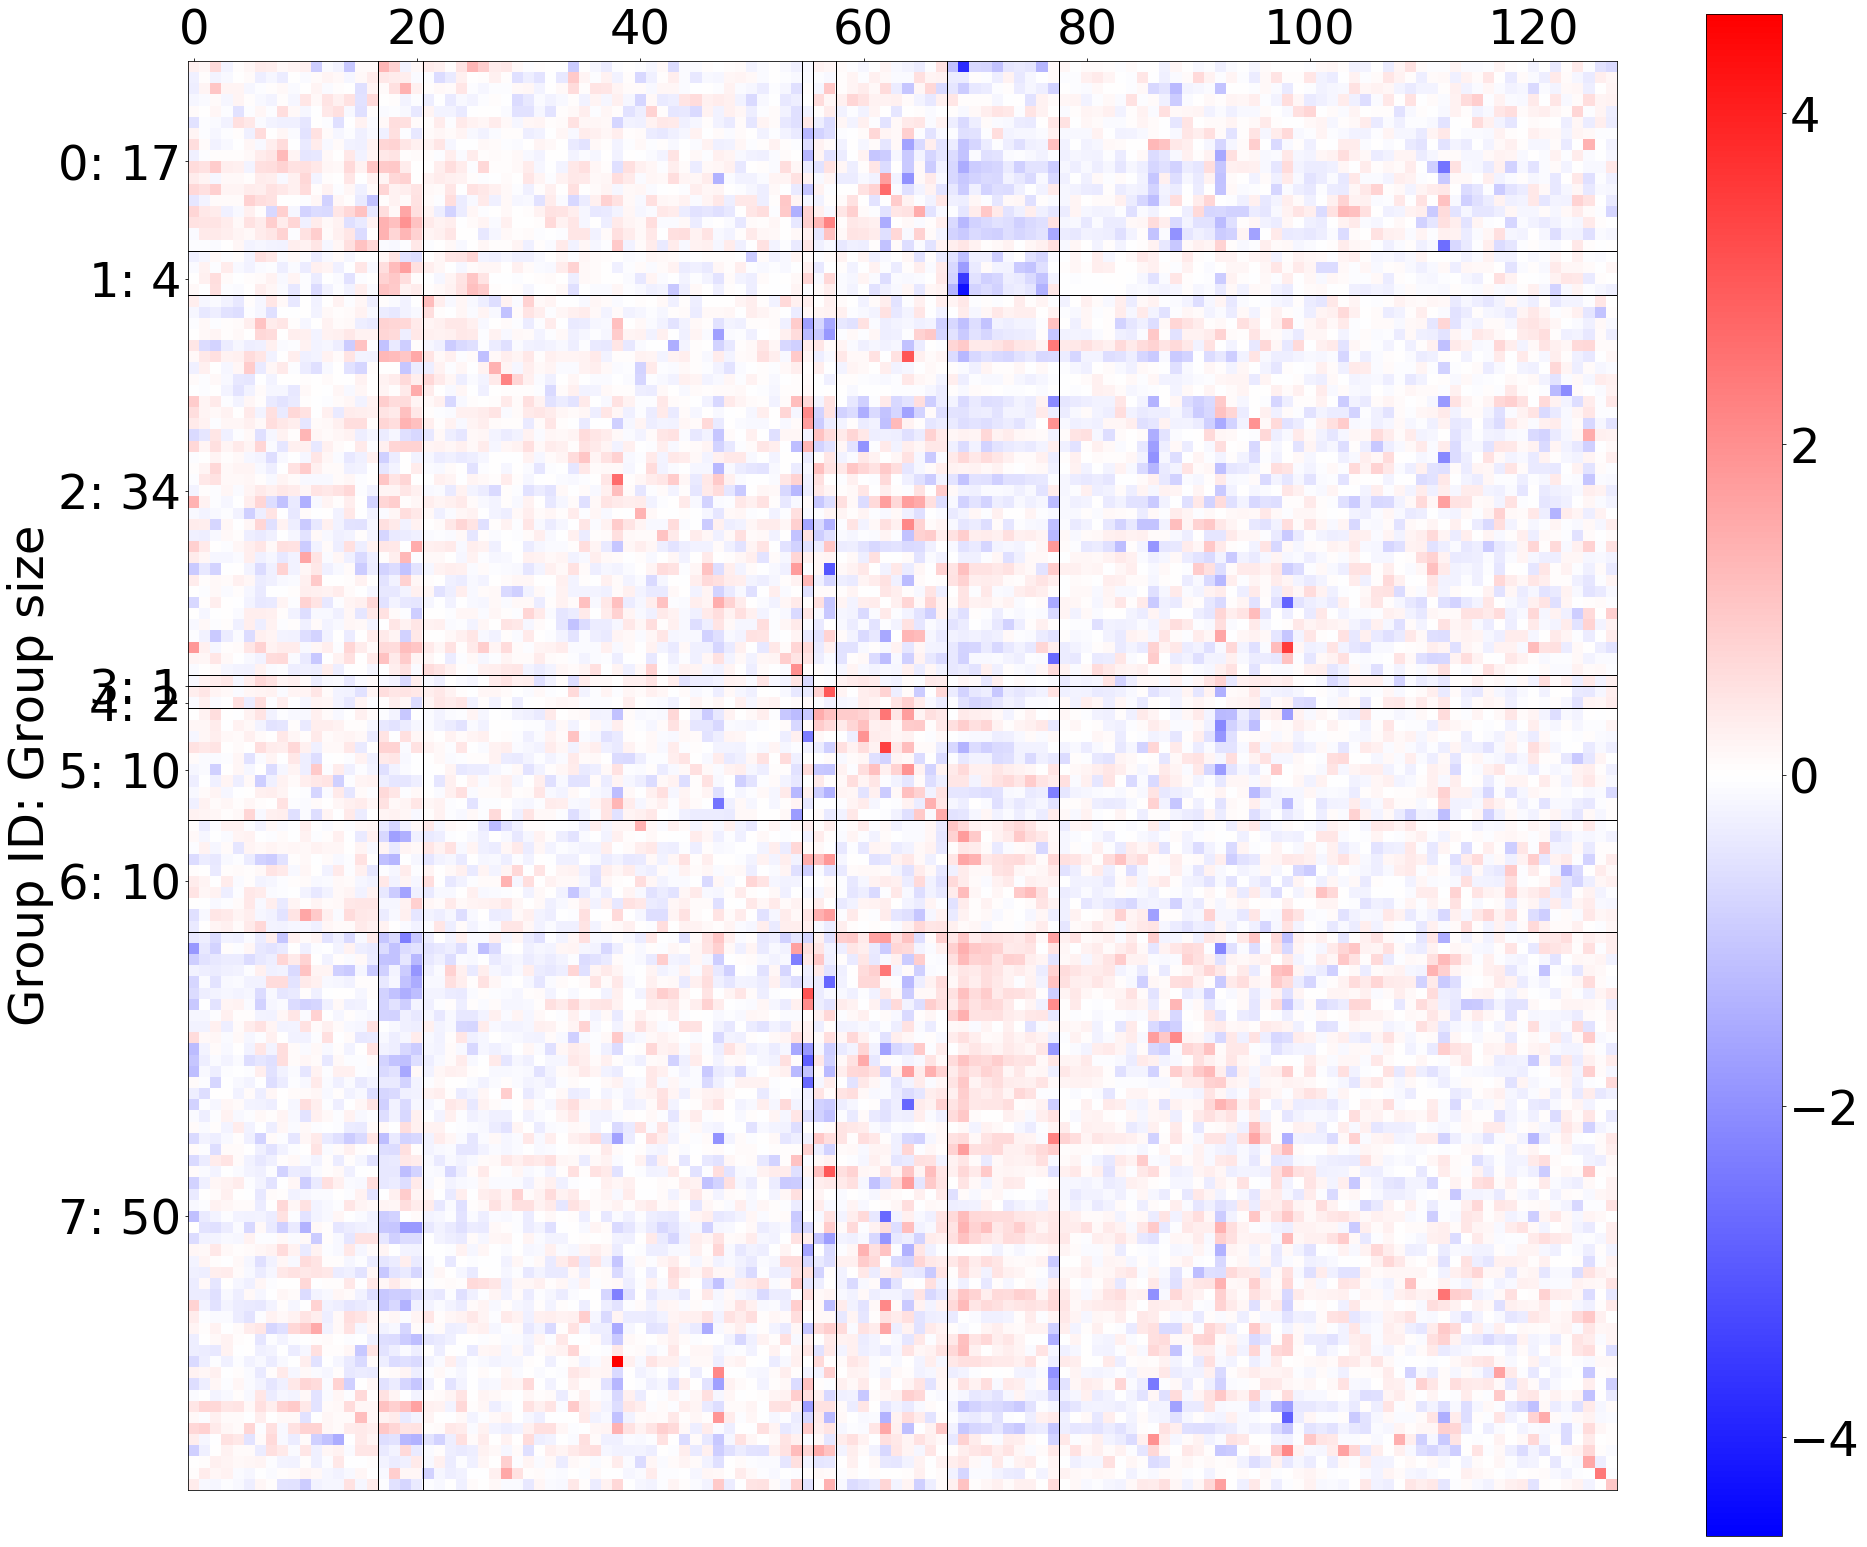

In [24]:
groups = Cell.analyze_weights(W_hn, 8)

In [25]:
for g, group in enumerate(groups):
    print(f'{g}:\t{group}')

0:	[43, 83, 89, 84, 64, 116, 110, 90, 11, 125, 55, 46, 2, 127, 67, 72, 108]
1:	[3, 117, 104, 114]
2:	[38, 76, 113, 91, 28, 68, 122, 30, 1, 42, 52, 88, 85, 77, 56, 26, 107, 80, 14, 51, 57, 115, 62, 12, 120, 45, 87, 48, 118, 21, 8, 121, 124, 126]
3:	[58]
4:	[23, 78]
5:	[47, 109, 86, 33, 95, 74, 103, 10, 94, 4]
6:	[24, 36, 59, 82, 73, 53, 6, 39, 97, 44]
7:	[0, 37, 35, 92, 65, 99, 93, 7, 9, 54, 18, 22, 27, 79, 16, 102, 105, 25, 20, 17, 106, 41, 112, 32, 40, 34, 61, 69, 5, 111, 29, 15, 75, 31, 49, 123, 13, 98, 81, 96, 19, 63, 101, 60, 50, 100, 119, 70, 66, 71]


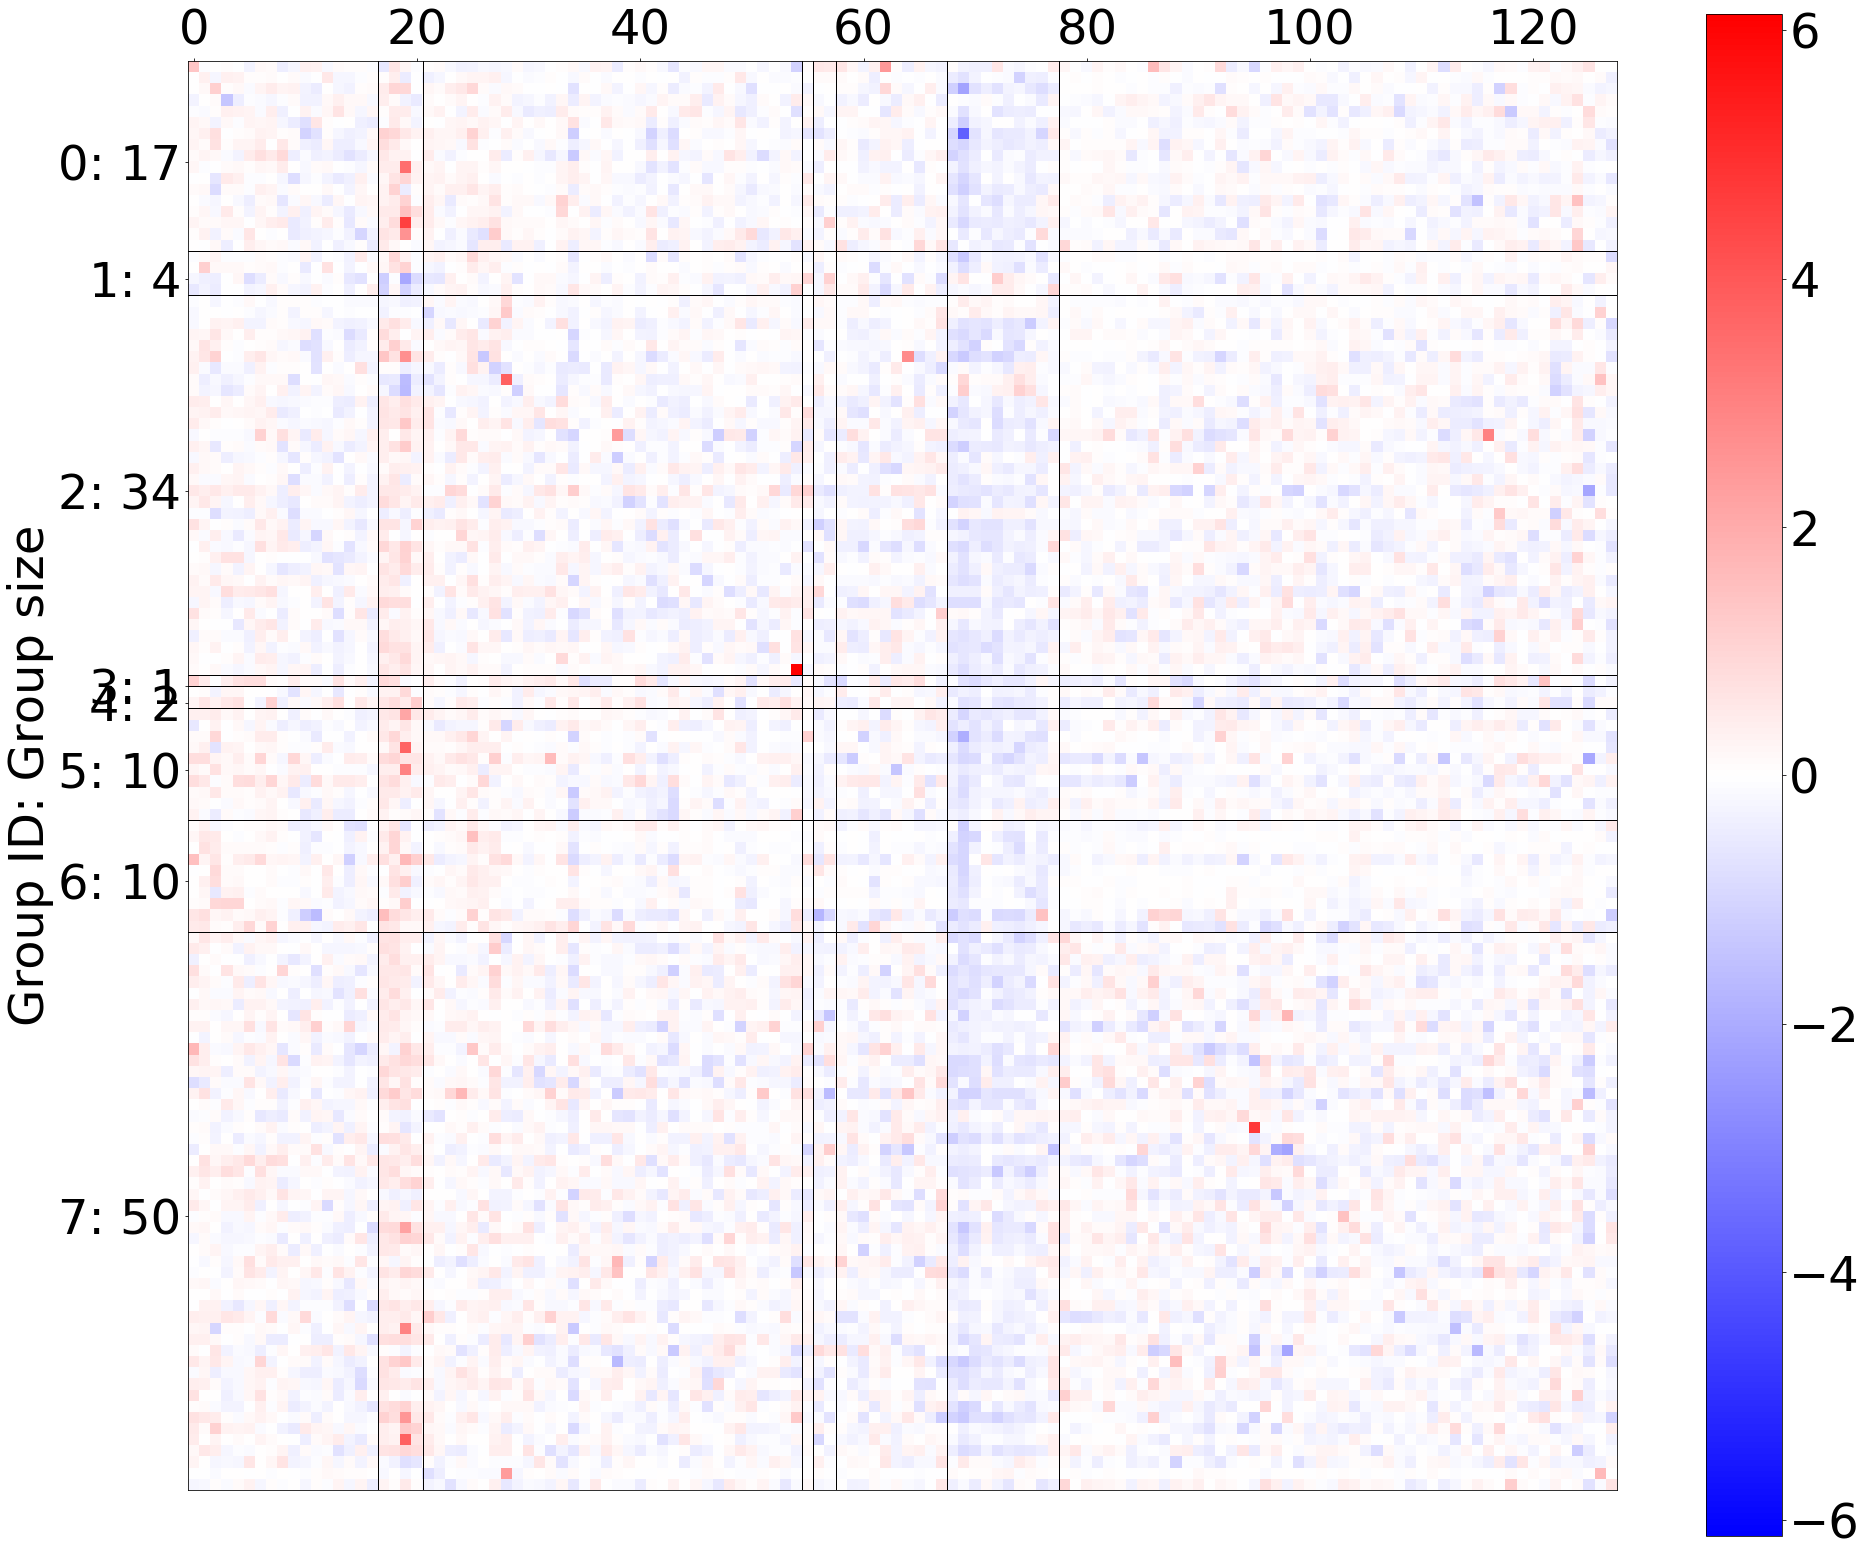

In [26]:
Cell.plot_weights(W_hz, groups)

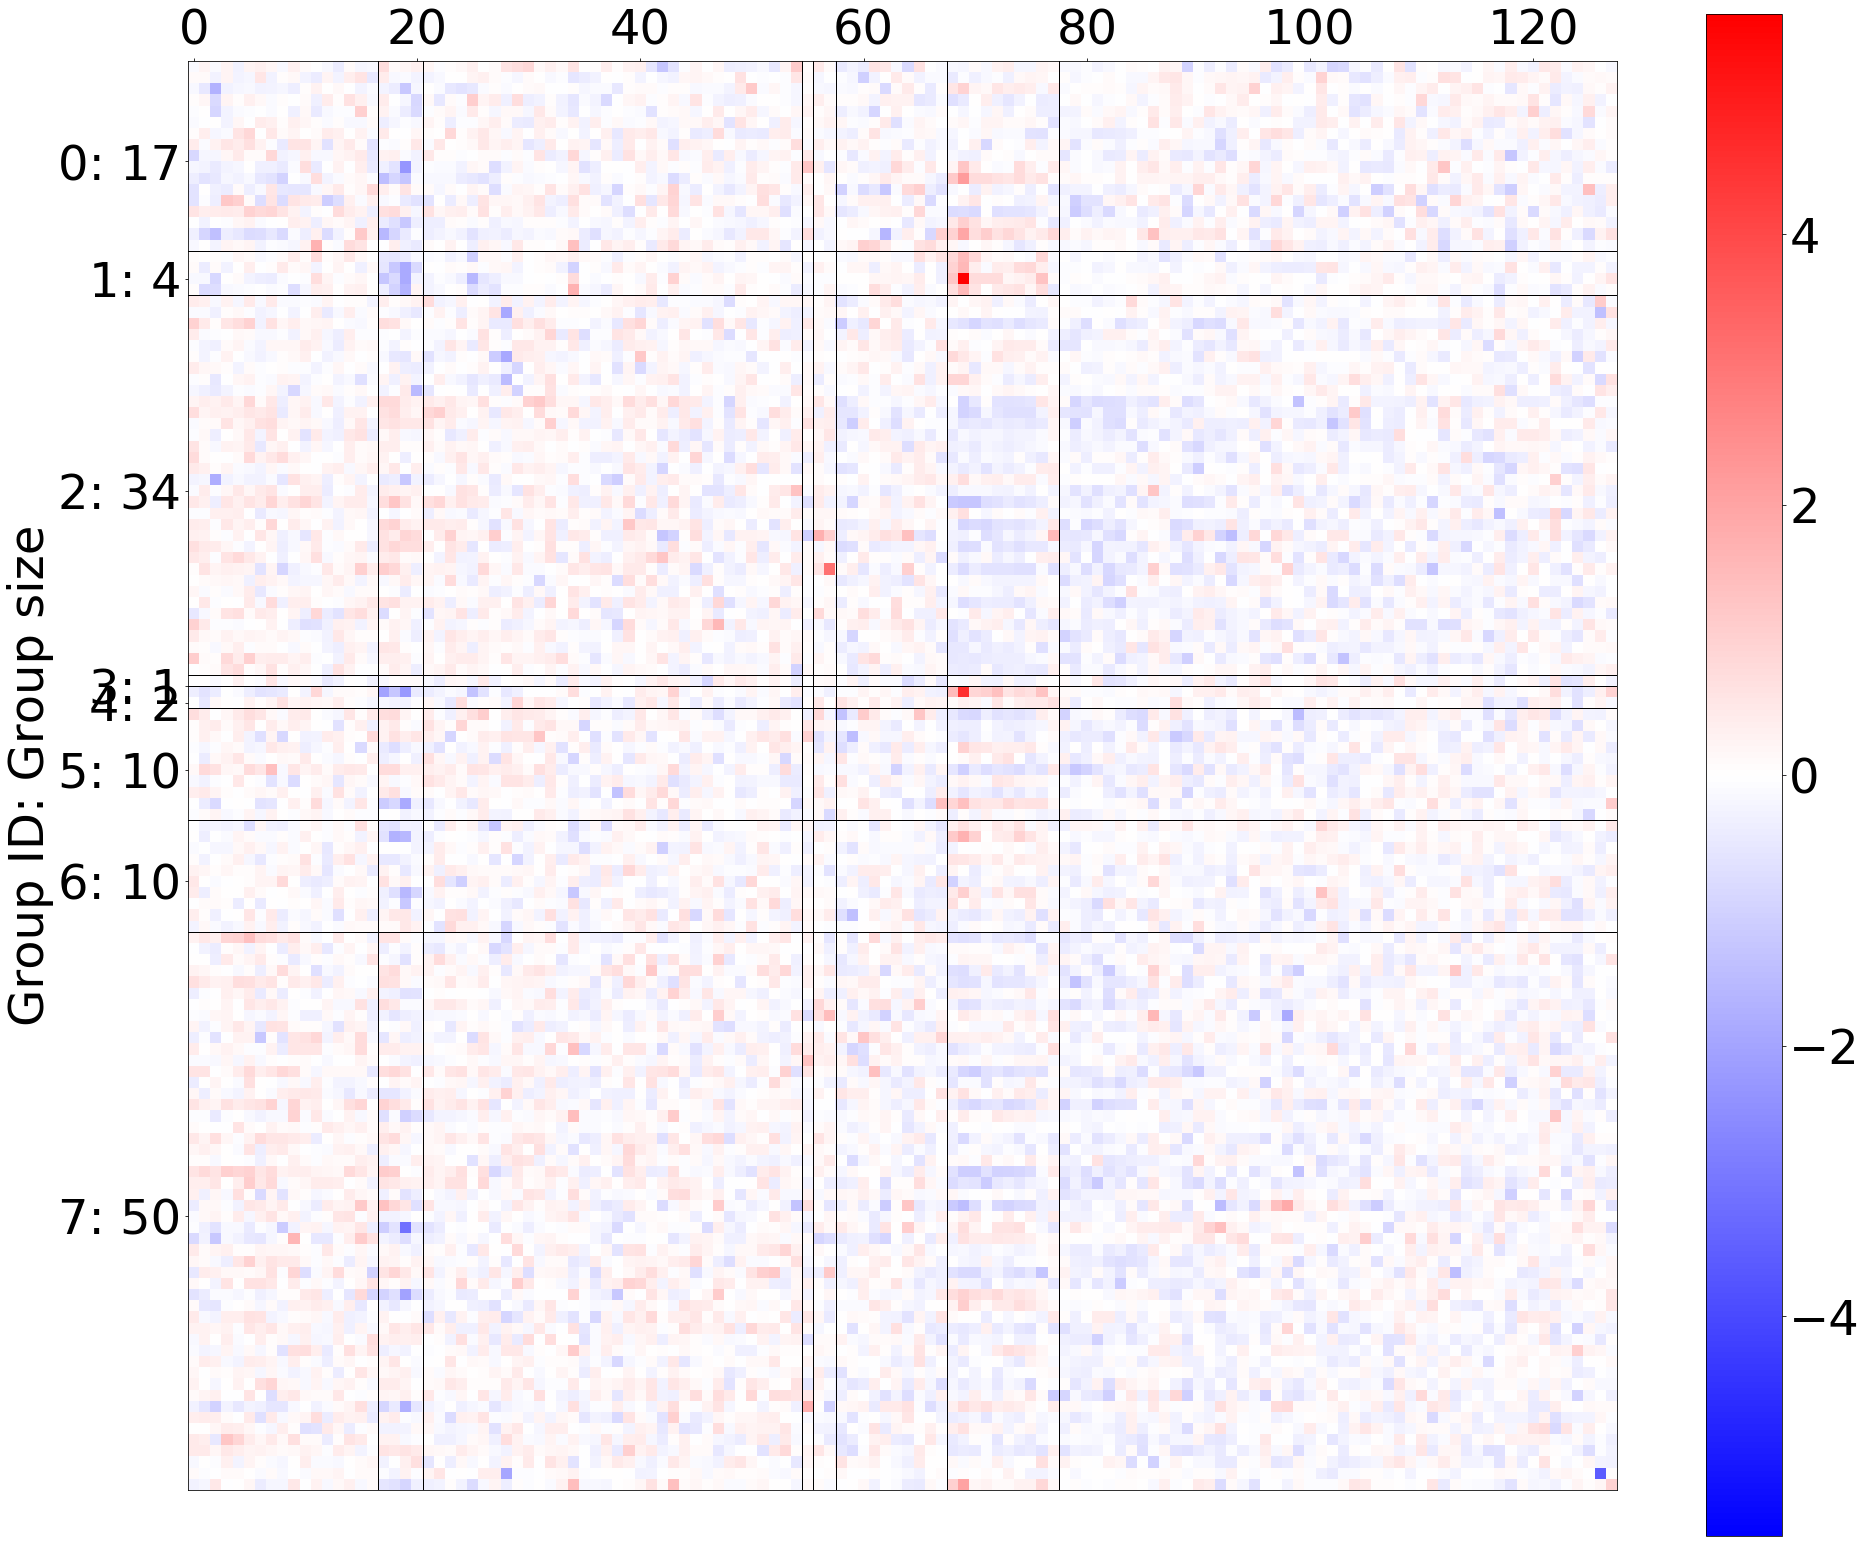

In [27]:
Cell.plot_weights(W_hr, groups)

## Implement GRU Cell to collect cell states while inferencing

In [28]:
import torch.nn.functional as F

def Deconstruction(model,x,x_len):
    
    # Encoder 
    encoder_hiddens, context = model.encoder(x,x_len)
    
    # Decoder
    decoder_hidden = context.squeeze(0)
    
    # Collection signal
    decoder_outputs = []
    decoder_hiddens = []
    decoder_resetGates = []
    decoder_updateGates = []
    decoder_newGates = []
    
    for iteration in range(15):
        
        # GRU Cell
        gru = model.decoder.cell
        
        U_h = F.linear(decoder_hidden, gru.weight_hh)
        Ur_h, Uz_h, Un_h = U_h.chunk(3, 1)
        reset_gate = torch.sigmoid(Ur_h)
        update_gate = torch.sigmoid(Uz_h)
        new_gate  = torch.tanh(reset_gate * Un_h)
        decoder_hidden = new_gate + update_gate * (decoder_hidden - new_gate)
        
        # Classifier
        clf_output = model.decoder.clf(decoder_hidden)
        decoder_output = model.decoder.log_softmax(clf_output)
        
        # mask specific cells
        mask = torch.ones(128)
        for cell in disabled_cells:
            mask[cell] = 0
        decoder_hidden *= mask
        
        # save states
        decoder_resetGates.append(reset_gate)
        decoder_updateGates.append(update_gate)
        decoder_newGates.append(new_gate)
        decoder_outputs.append(decoder_output)            
        decoder_hiddens.append(decoder_hidden)
                                                   
        if torch.all(decoder_output.argmax(-1)==EOS) == True:
            break
            
    outputs = torch.stack(decoder_outputs,dim=2)             # (b,6xxx,s)
    
    gru_info = {
        'hiddens':torch.stack(decoder_hiddens,dim=2),             # (b,128,s)
        'resetgates':torch.stack(decoder_resetGates,dim=2),       # (b,128,s)
        'updategates':torch.stack(decoder_updateGates,dim=2),     # (b,128,s)
        'newgates':torch.stack(decoder_newGates,dim=2)            # (b,128,s)
    }
    
    return outputs, gru_info

## Generate certain condition valid datas ( by designated word / position filter )

In [29]:
def get_certain_set(pos, word, show=False):
    certain_set = []

    designated_POS = pos
    designated_word = word

    for sent in random.sample(corpus, k=128):

        control_signal = [str(designated_POS) , designated_word]

        data = ['<SOS>'] + sent + ['<EOS>'] + control_signal

        if show:
            print(data)

        certain_set.append(data)

    dataset_certain = TestDataset(certain_set)
    return dataset_certain

## Prediction certain condition data

In [30]:
def predict(dataset):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=128,
                            shuffle=False,
                            collate_fn=dataset.collate_fn,
                            num_workers=0)

    predictions = []
    trange = tqdm(dataloader, total=len(dataloader))

    for x,x_len in trange:

        x = x.to(device)

        outputs, gru_info = Deconstruction(model,x,x_len)

        for pred in outputs.cpu().detach().numpy().argmax(1):
            predictions.append(pred)
    return predictions, gru_info

In [31]:
def untokenize_output(dataset, predictions):
    # Process multi-EOS tokens
    predictions_set = []
    for p in predictions:
        p = list(p)
        if EOS in p:
            p = p[:p.index(EOS)+1]
        else:
            p.append(EOS)
        predictions_set.append(embedder.unTokenize(p))

    for sent_id in range(len(dataset)):
        sent_in = ''.join(dataset[sent_id])
        sent_pred = ''.join(predictions_set[sent_id])
        print(f'input:\t{sent_in}\npred:\t{sent_pred}\n')

## Cell classification

In [32]:
import Cell

In [33]:
# disabled_cells = {*(groups[7][:20])}
disabled_cells = {}

In [34]:
# certain_set = get_certain_set(8, draw('张朦胧的话只是无聊的暗号'))
certain_set = get_certain_set(5, '女')

In [35]:
import numpy as np

predictions, gru_info = predict(certain_set)

gates = {'input': gru_info['updategates'].detach().cpu().numpy(),
         'reset': gru_info['resetgates'].detach().cpu().numpy(),
         'new': gru_info['newgates'].detach().cpu().numpy(),
         'hidden': gru_info['hiddens'].detach().cpu().numpy()} # (b,128,s)

gates_avg = {}
gates_std = {}
for key, value in gates.items():
    gates_avg[key] = value.mean(0) # (128,s)
    gates_std[key] = value.std(0) # (128,s)

output_len = gates['input'].shape[2]
print(output_len)


7


In [36]:
untokenize_output(certain_set, predictions)

input:	<SOS>逆着风刀走过暴雨的街<EOS>5女
pred:	<SOS>我的的的女<EOS>

input:	<SOS>开解在哭的我<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>而拥有一辆私人小汽车<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>你跑去哪里了<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>留我独自伤悲<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>我的梦想你的是否一样<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>不要逼我出手给你断粮<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>哎呀哎哎呀<EOS>5女
pred:	<SOS>我们的的女<EOS>

input:	<SOS>看起来像那么回事<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>他不停的尝试接收期待明天<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>不要离开好不好<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>车窗上的雾气那灰色的<EOS>5女
pred:	<SOS>我的的的女<EOS>

input:	<SOS>或那一种交流相处<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>不需要<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>我心痛<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>撑着不承认绝望<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>就像那年匆促刻下永远一起那样美丽的谣言<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>无辜的沉默<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>这儿呐<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>王燃烧青春照亮我和你<EOS>5女
pred:

input--------------------
cells: [3, 104, 114, 117]


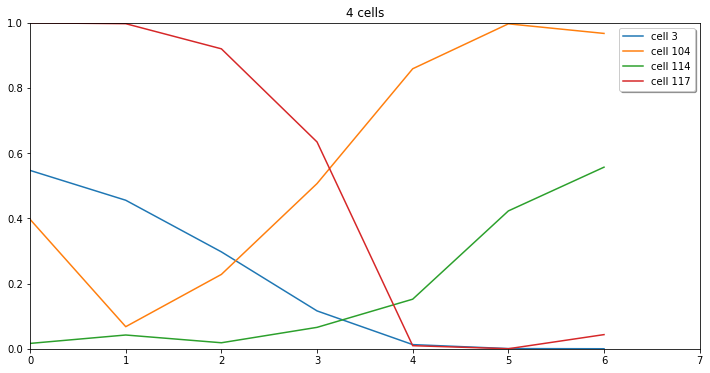

cells: [3, 104, 114, 117]


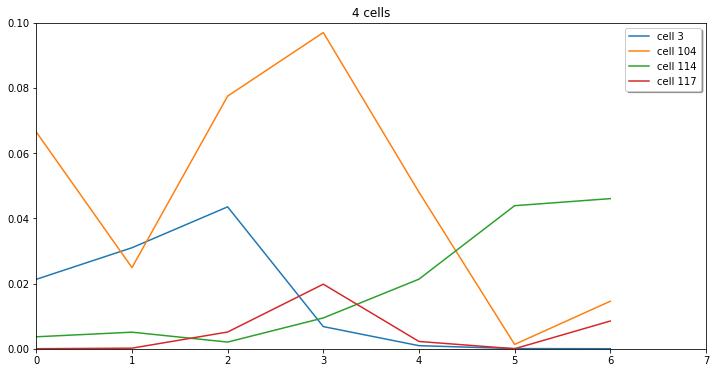

new--------------------
cells: [3, 104, 114, 117]


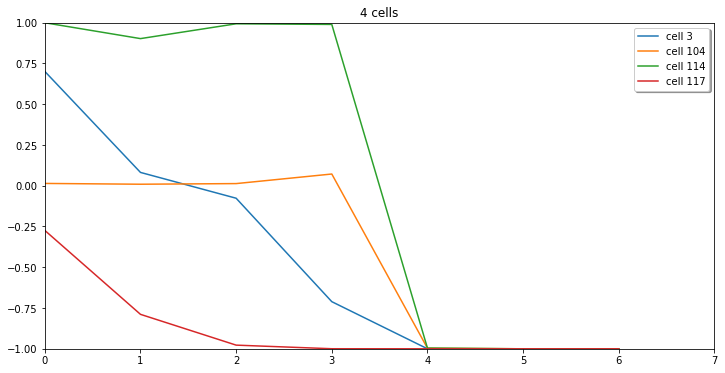

cells: [3, 104, 114, 117]


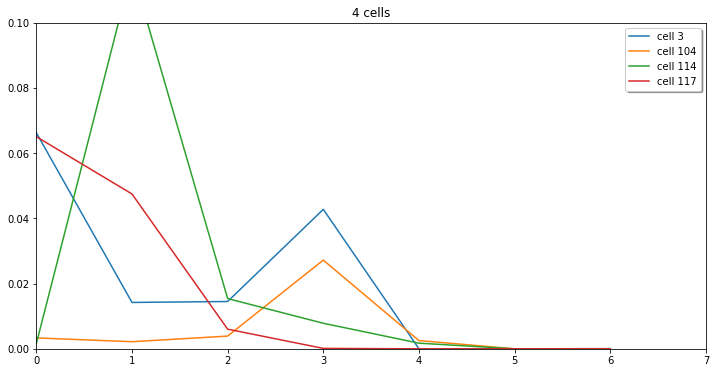

reset--------------------
cells: [3, 104, 114, 117]


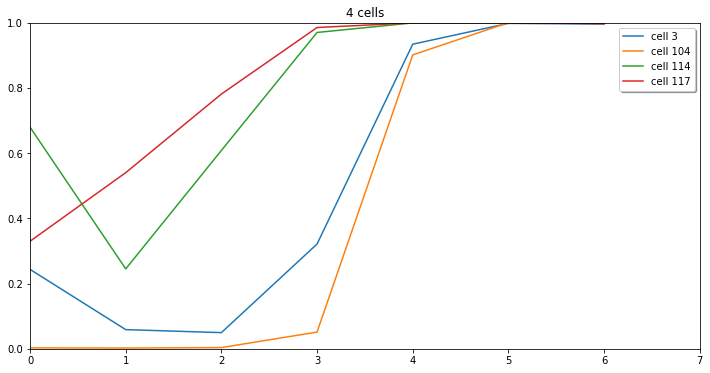

cells: [3, 104, 114, 117]


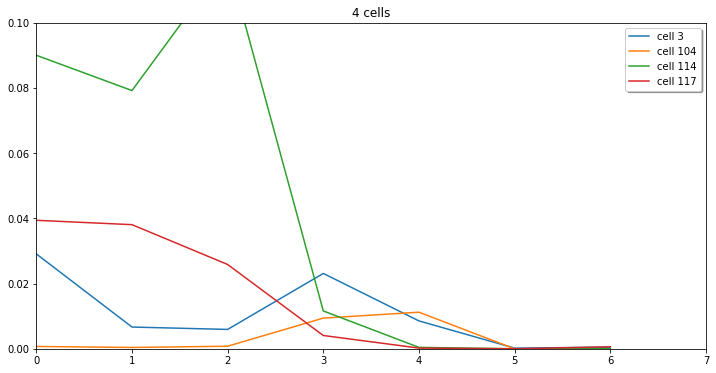

hidden--------------------
cells: [3, 104, 114, 117]


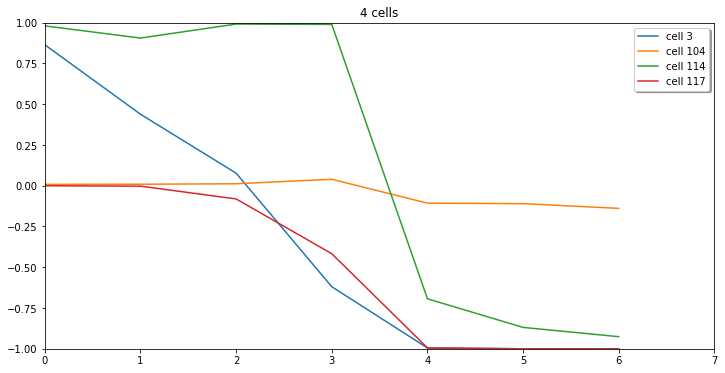

cells: [3, 104, 114, 117]


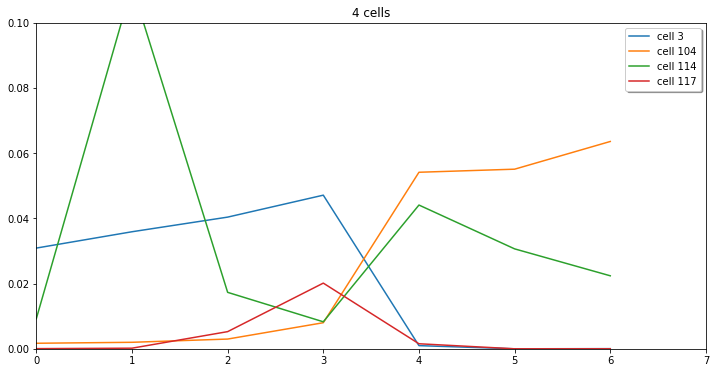

In [37]:
n = 1
print('input--------------------')
Cell.plot(gates_avg['input'], picked=groups[n], show_legend=True)
Cell.plot(gates_std['input'], picked=groups[n], show_legend=True, ylim=(0,0.1))
print('new--------------------')
Cell.plot(gates_avg['new'], picked=groups[n], show_legend=True, ylim=(-1,1))
Cell.plot(gates_std['new'], picked=groups[n], show_legend=True, ylim=(0,0.1))
print('reset--------------------')
Cell.plot(gates_avg['reset'], picked=groups[n], show_legend=True)
Cell.plot(gates_std['reset'], picked=groups[n], show_legend=True, ylim=(0,0.1))
print('hidden--------------------')
Cell.plot(gates_avg['hidden'], picked=groups[n], show_legend=True, ylim=(-1,1))
Cell.plot(gates_std['hidden'], picked=groups[n], show_legend=True, ylim=(0,0.1))

In [38]:
[16-len({59,90,91,33,110,117,71,82,24,36,21,39,73,119,97,98}-set(group)) for group in groups]

[2, 1, 2, 0, 0, 1, 7, 3]

types: {
'count_down': {33, 97, 98, 36, 71, 39, 59, 73, 110, 82, 117, 21, 119, 24, 90, 91},
}
cells: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 120, 121, 122, 123, 124, 125, 126, 127]


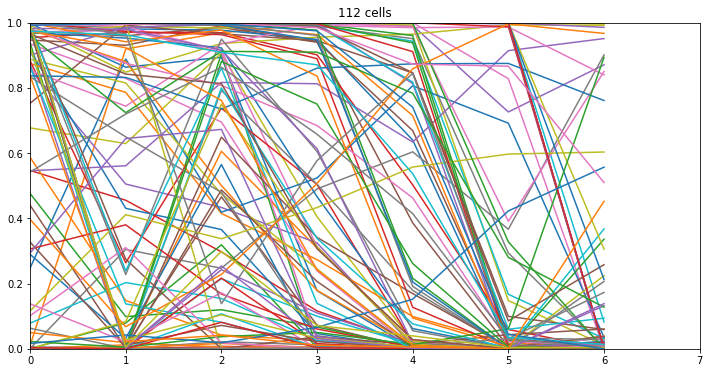

In [39]:
cell_types = {
#     'EOS': {9, 44, 49, 58, 78, 87, 106},
#     'designated': {10, 15, 19, 47, 57, 60, 62, 82},
#     'large': {35, 36, 104},
#     'test': {4, 7, 10, 15, 18, 19, 24, 47, 50, 57, 60, 62, 67, 68, 77, 82, 96, 116},
    'count_down': {59,90,91,33,110,117,71,82,24,36,21,39,73,119,97,98},
}

# cell_types['xxx10'] = picked

included = set(range(len(gates_avg['input'])))
print('types: {')
for key, value in cell_types.items():
    print(f"'{key}': {value},")
    included -= value
print('}')
Cell.plot(gates_avg['input'], picked=included)

count_down:----------------------
cells: [21, 24, 33, 36, 39, 59, 71, 73, 82, 90, 91, 97, 98, 110, 117, 119]


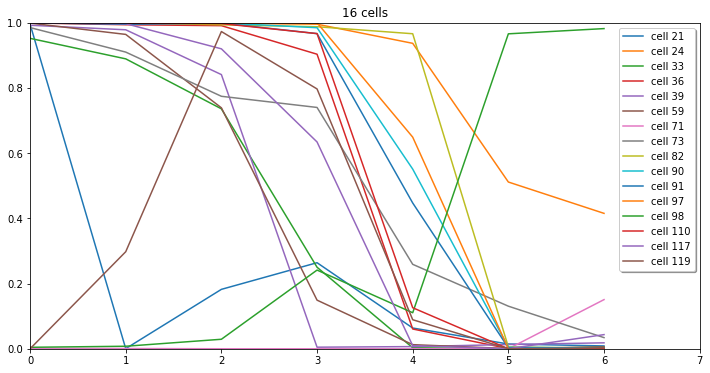

cells: [21, 24, 33, 36, 39, 59, 71, 73, 82, 90, 91, 97, 98, 110, 117, 119]


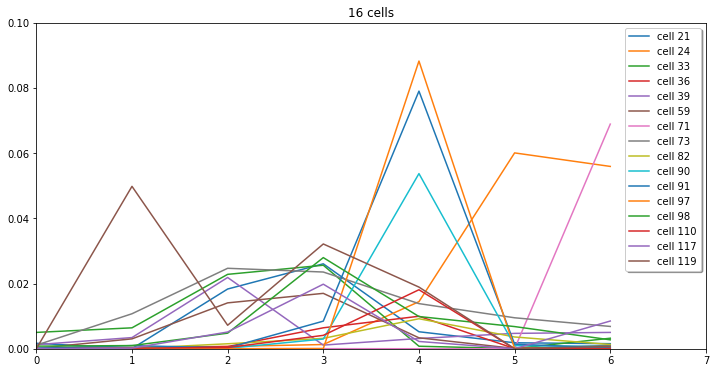

In [40]:
for key, value in cell_types.items():
    print(f'{key}:----------------------')
    Cell.plot(gates_avg['input'], picked=value, show_legend=True)
    Cell.plot(gates_std['input'], picked=value, show_legend=True, ylim=(0,0.1))

cells: [9, 16, 44, 49, 58, 78, 87, 95, 103, 106, 122]


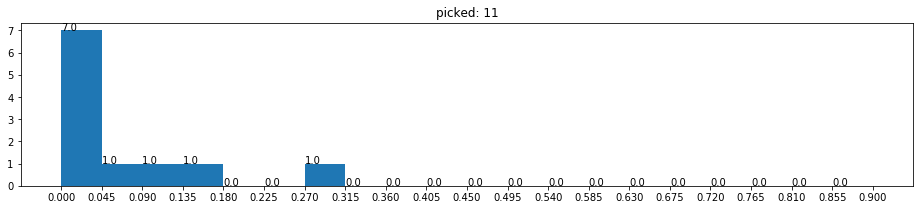

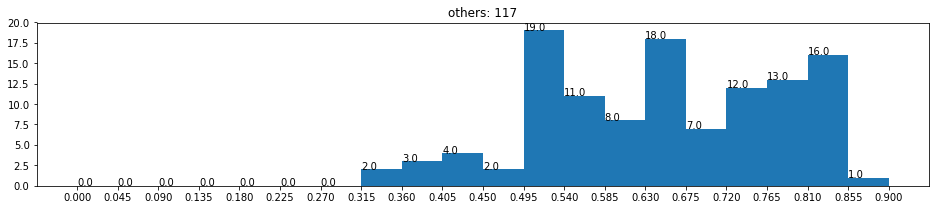

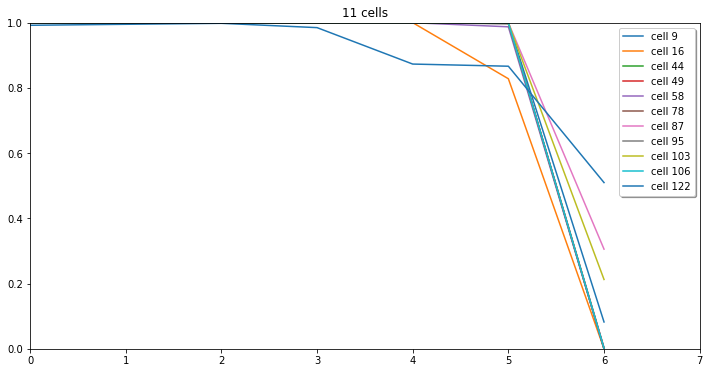

In [41]:
picked = Cell.pick(gates_avg['input'],
    [1,1,1,1,1,1,0],
    [1,1,1,1,1,3,3],
    lambda d: d<0.3,# and d>0.3,
    max_diff=0.9,
#     picked=included,
)

average of squared distances of samples to centers: 0.07282641347884534
average of squared distances of centers to centers: 2.1609520321800595
ratio: 29.67264113325825
-----------------------------
group 0: [0.94835657 0.894128   0.8302425  0.23467532 0.01525208 0.00190929
 0.00894451]
cells: [0, 6, 8, 28, 33, 39, 41, 45, 59, 115, 121]


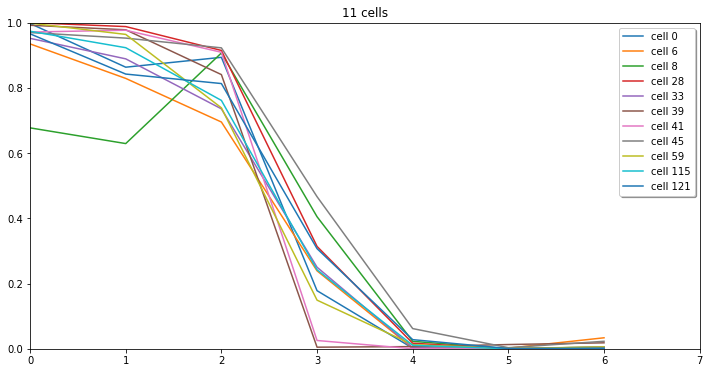

-----------------------------
group 1: [0.7983796  0.6852089  0.40434164 0.1404627  0.01604524 0.00250044
 0.064732  ]
cells: [3, 14, 20, 22, 46, 53, 64, 75, 107]


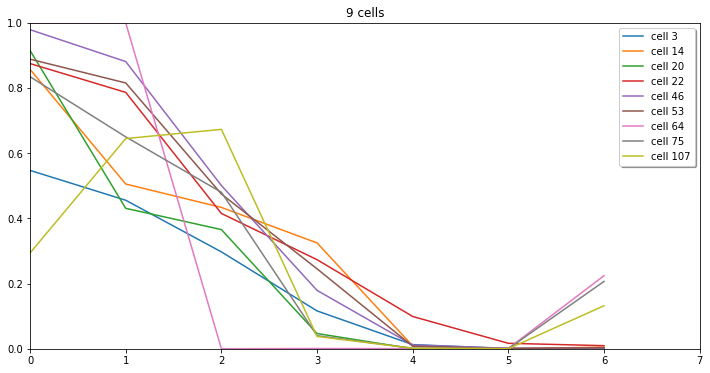

-----------------------------
group 2: [0.91856873 0.05247957 0.11888772 0.05094582 0.01308799 0.00539495
 0.06270363]
cells: [2, 21, 26, 34, 65, 84, 102, 108, 112, 120, 124, 127]


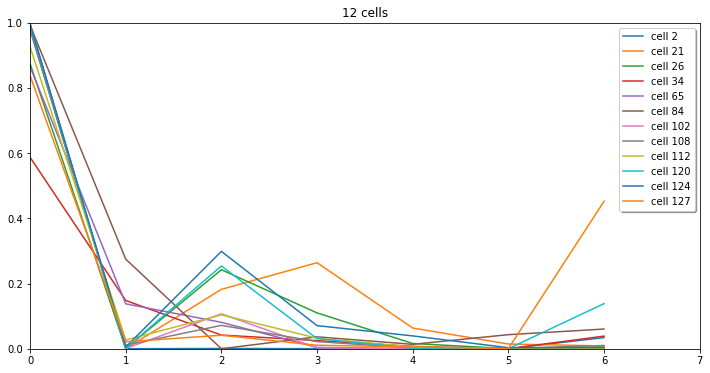

-----------------------------
group 3: [0.9554075  0.10741493 0.84654653 0.40601563 0.08433369 0.00169152
 0.00294191]
cells: [12, 37, 42, 52, 88, 93, 113]


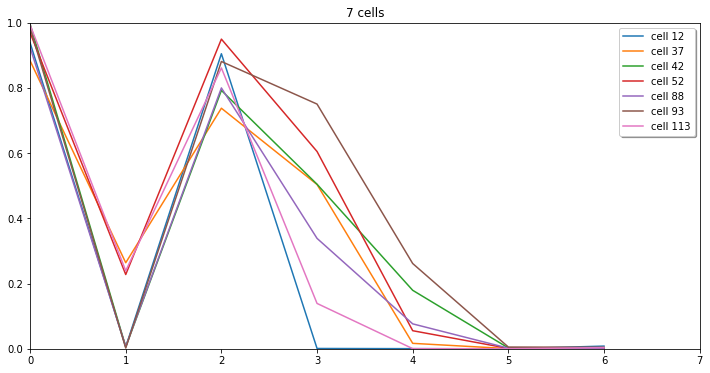

-----------------------------
group 4: [0.08846104 0.061975   0.64217395 0.29207617 0.04422951 0.0007986
 0.00932363]
cells: [11, 27, 55, 61, 72, 101, 119]


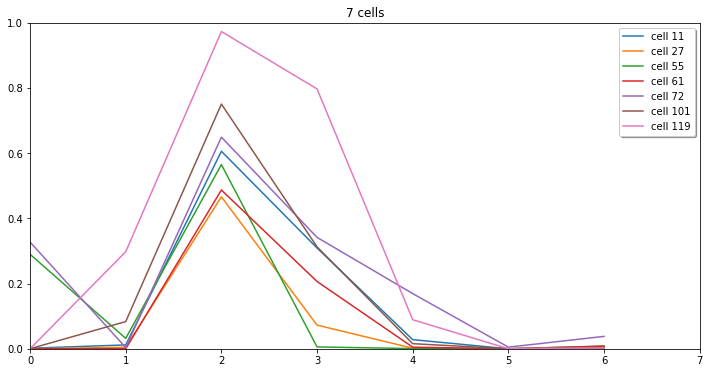

-----------------------------
group 5: [0.09267265 0.06238824 0.08440566 0.0171454  0.00255331 0.0021376
 0.06312898]
cells: [13, 23, 29, 31, 35, 40, 54, 56, 63, 69, 71, 79, 85, 94, 99, 109, 111, 118]


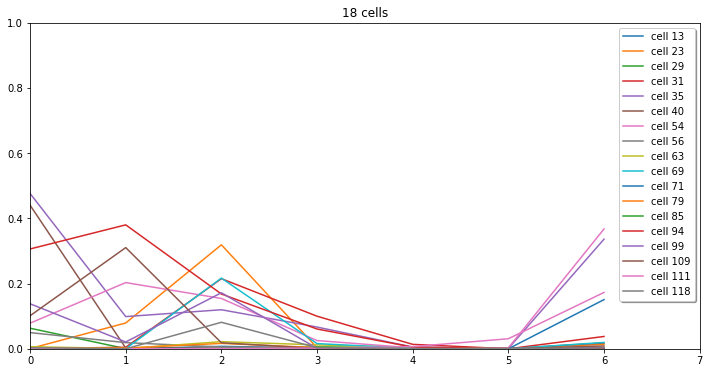

-----------------------------
group 6: [0.01937777 0.02365237 0.02788091 0.05793455 0.08278012 0.24205813
 0.72510946]
cells: [105, 114]


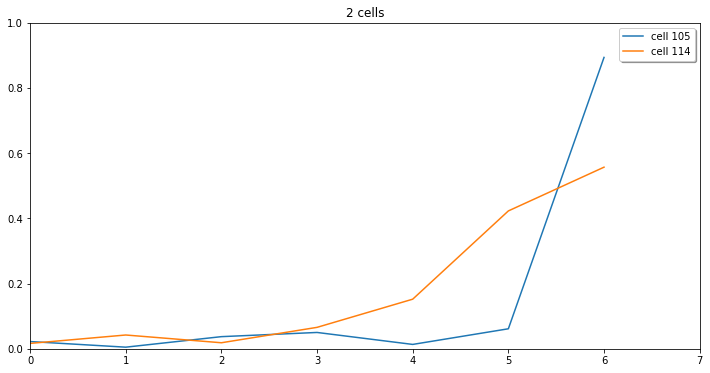

-----------------------------
group 7: [0.12963593 0.19791237 0.21044964 0.41783267 0.5325504  0.7314304
 0.8632196 ]
cells: [17, 76, 98, 104]


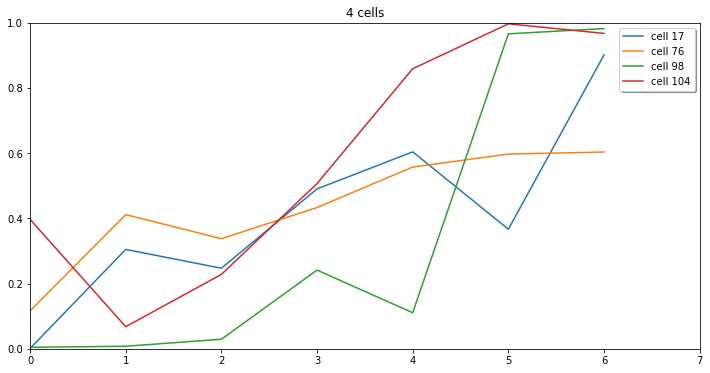

-----------------------------
group 8: [0.24763373 0.88848525 0.41879943 0.5236757  0.8063473  0.6917564
 0.03520285]
cells: [32]


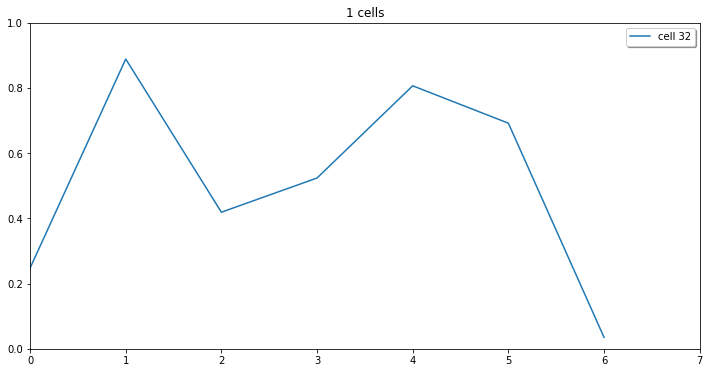

-----------------------------
group 9: [0.99818236 0.9664641  0.1383875  0.576931   0.8445385  0.03369623
 0.0281128 ]
cells: [100]


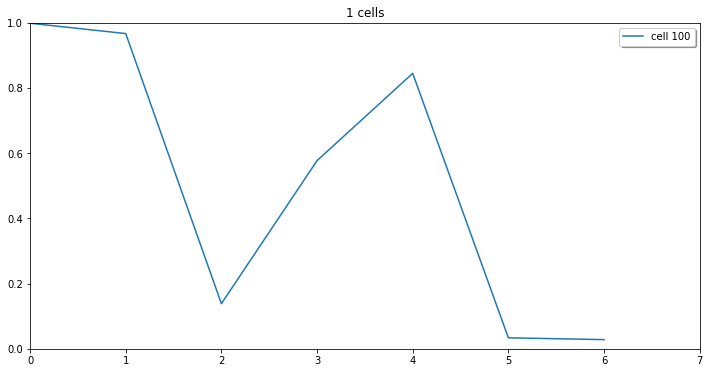

-----------------------------
group 10: [0.9793408  0.9786471  0.98997504 0.97910273 0.8279798  0.08461466
 0.03172764]
cells: [7, 10, 15, 18, 19, 47, 50, 57, 60, 67, 77, 80, 81, 82, 90, 96, 97, 116, 126]


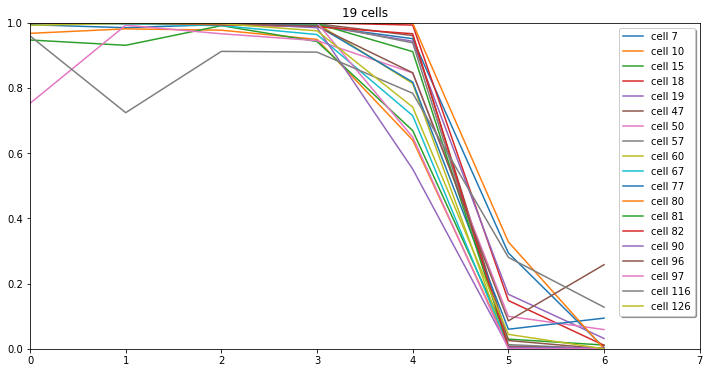

-----------------------------
group 11: [0.9617841  0.95450044 0.94109595 0.84296125 0.25348854 0.0187657
 0.00807205]
cells: [5, 25, 36, 48, 68, 73, 74, 83, 86, 89, 91, 92, 110, 117, 123, 125]


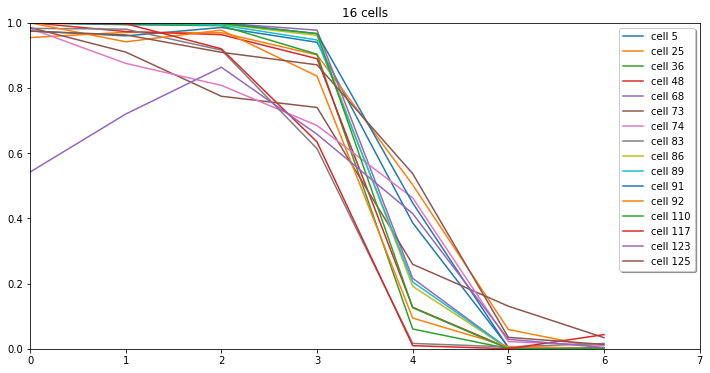

-----------------------------
group 12: [0.99763143 0.99833375 0.9985671  0.99406374 0.9471041  0.623688
 0.6614456 ]
cells: [4, 24, 62, 122]


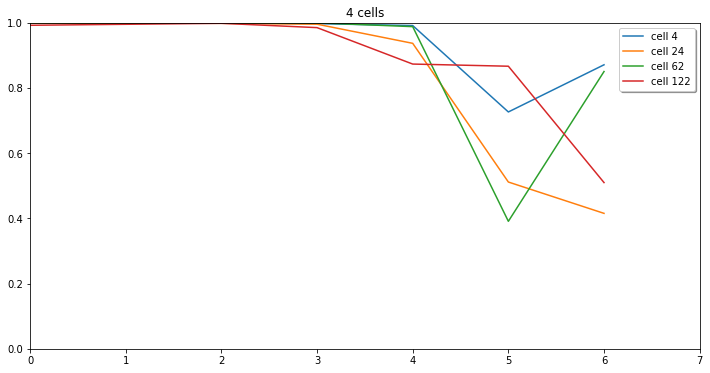

-----------------------------
group 13: [0.72915244 0.83994126 0.9100415  0.94488907 0.9219319  0.9667595
 0.9319234 ]
cells: [1, 30, 38, 43, 51, 66, 70]


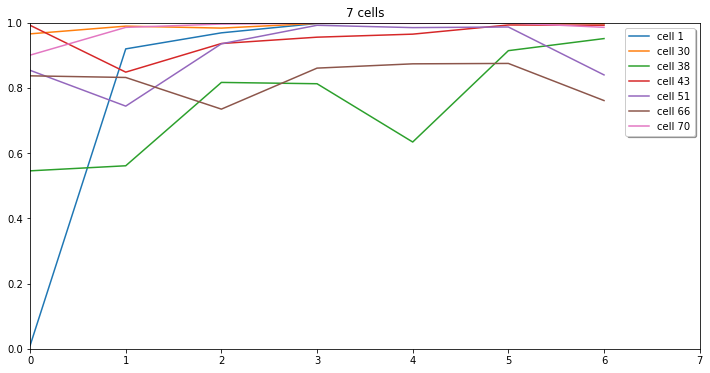

-----------------------------
group 14: [0.99997866 0.9999984  0.99999714 0.9999869  0.99995565 0.98075986
 0.06061026]
cells: [9, 16, 44, 49, 58, 78, 87, 95, 103, 106]


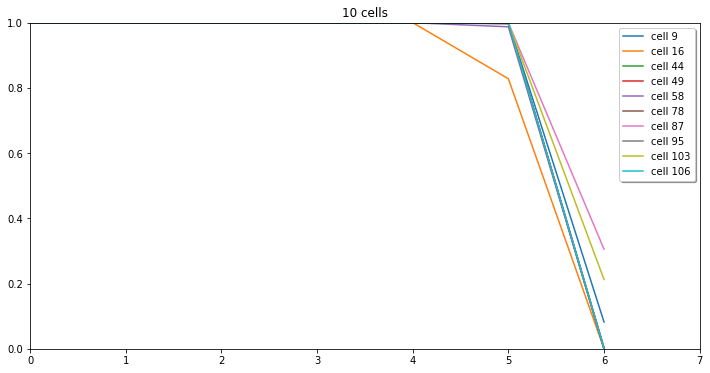

In [42]:
Cell.analyze(gates_avg['input'], 15)

average of squared distances of samples to centers: 0.059175685781530846
average of squared distances of centers to centers: 2.20906008765811
ratio: 37.33053632557265
-----------------------------
group 0: [0.97618127 0.99258757 0.95609206 0.9959428  0.99832505 0.99542016
 0.95044684]
cells: [6, 15, 25, 26, 28, 33, 34, 35, 46, 50, 67, 85, 86]


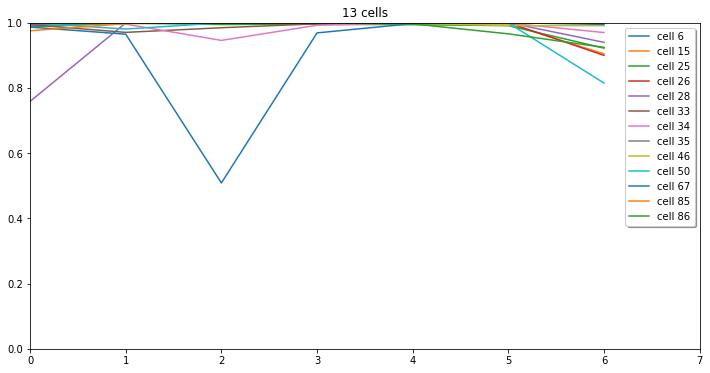

-----------------------------
group 1: [0.9445503  0.98468816 0.9732834  0.96957684 0.9761574  0.9764447
 0.5386818 ]
cells: [4, 8, 19, 48, 59, 60, 91, 97, 99]


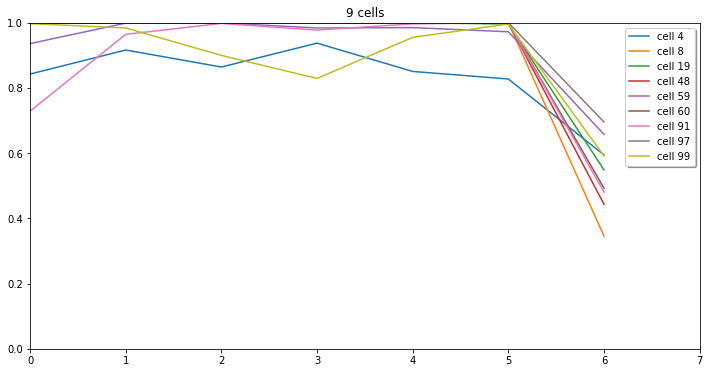

-----------------------------
group 2: [0.9871081  0.99565774 0.99904233 0.99292886 0.9880039  0.9742454
 0.05191532]
cells: [0, 5, 10, 11, 12, 13, 14, 17, 18, 20, 21, 27, 29, 38, 41, 42, 43, 44, 45, 47, 49, 52, 56, 57, 62, 63, 65, 73, 74, 77, 79, 80, 81, 83, 88, 90, 92, 93, 96, 100, 102, 109, 110, 111, 112, 113, 115, 119, 120, 121, 123, 124, 126, 127]


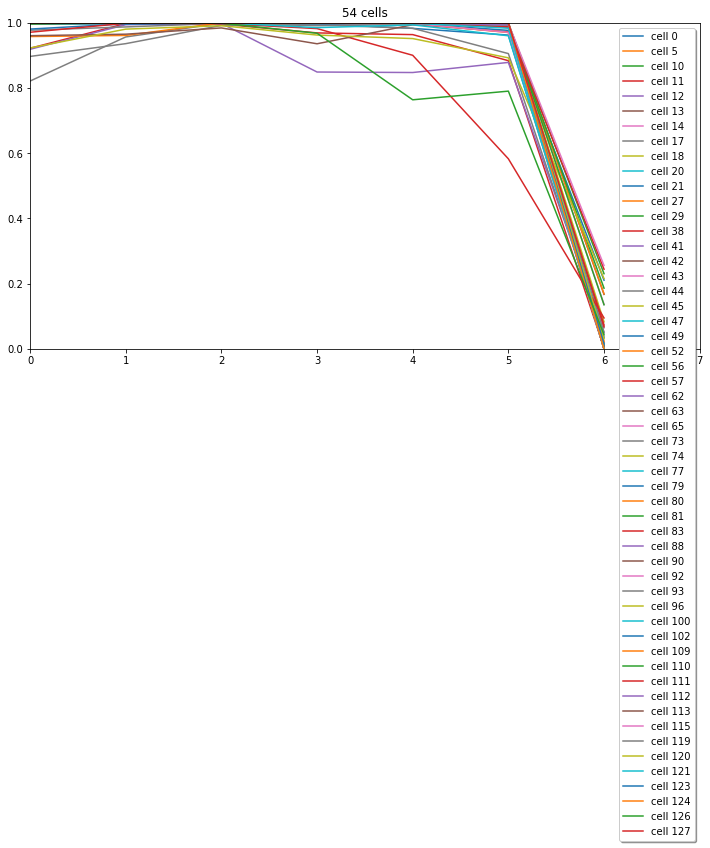

-----------------------------
group 3: [0.41823906 0.9278767  0.92278814 0.8480844  0.8345436  0.91384894
 0.9018065 ]
cells: [9, 22, 30, 37, 39, 53, 64, 68]


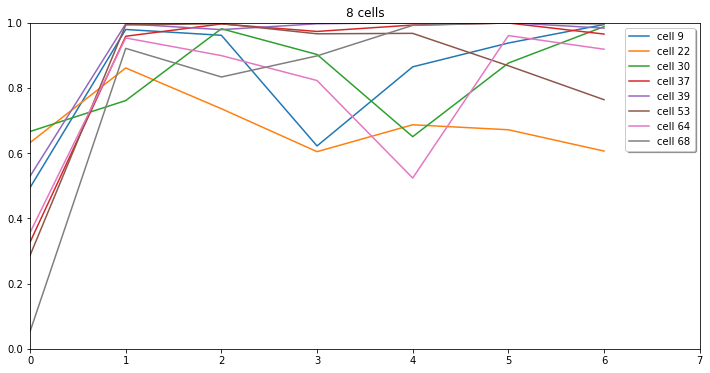

-----------------------------
group 4: [0.33923653 0.5238383  0.7280263  0.8526409  0.9604426  0.9955453
 0.9887506 ]
cells: [1, 36, 58, 78, 106, 114, 117]


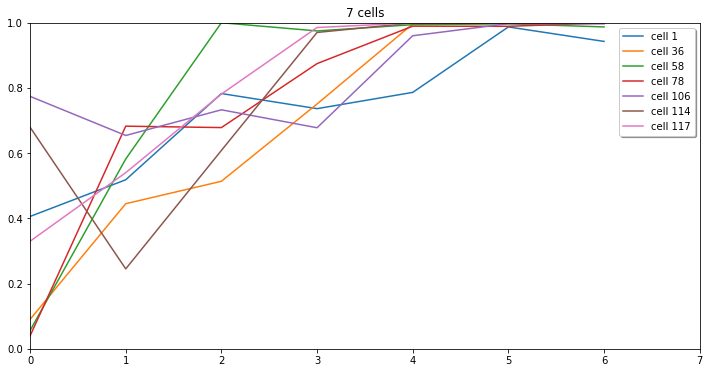

-----------------------------
group 5: [0.03158641 0.10634762 0.6561664  0.6830185  0.81932634 0.79745334
 0.4646467 ]
cells: [70, 116, 125]


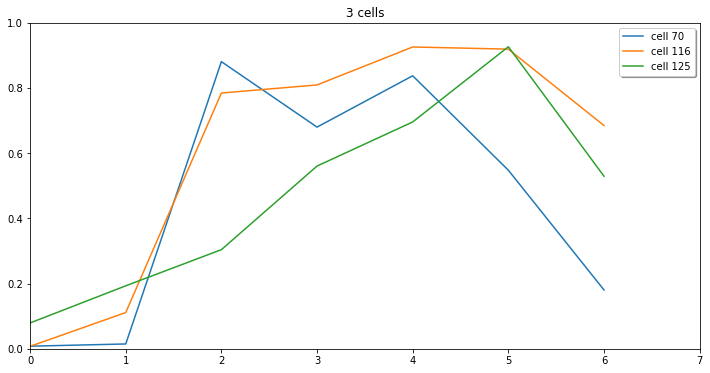

-----------------------------
group 6: [0.06683588 0.08706099 0.07684022 0.19136763 0.7357998  0.98891735
 0.9926636 ]
cells: [3, 16, 23, 24, 55, 82, 89, 94, 104, 107]


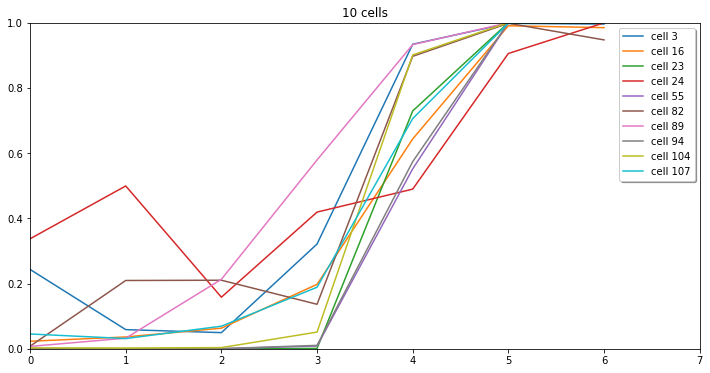

-----------------------------
group 7: [0.7380478  0.03129852 0.06078339 0.249419   0.83902687 0.99828374
 0.91743684]
cells: [31, 98, 105]


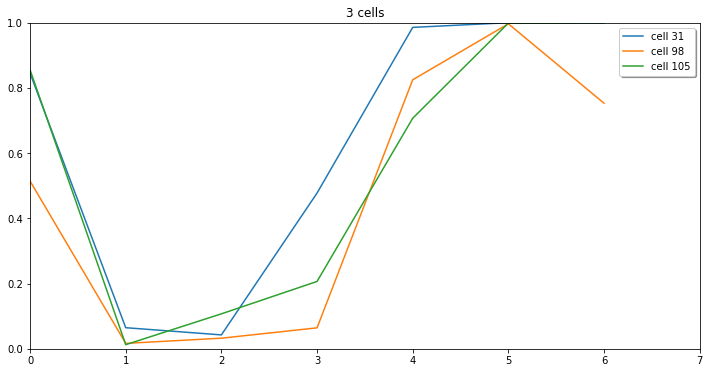

-----------------------------
group 8: [0.79580843 0.13386357 0.01927036 0.01231146 0.13024026 0.9452665
 0.99791074]
cells: [32, 61, 69, 71]


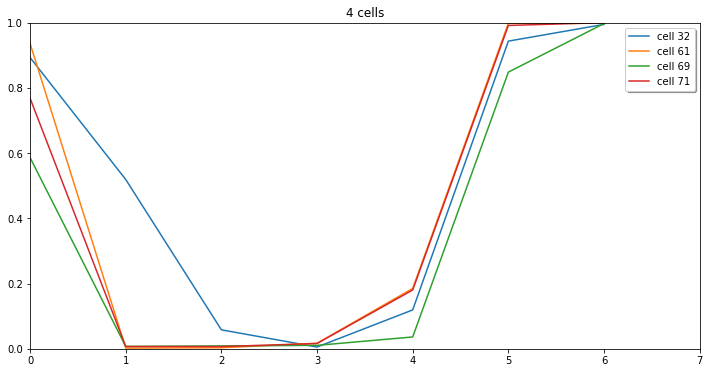

-----------------------------
group 9: [1.6337633e-04 7.3969364e-05 1.8447638e-04 1.3225675e-03 4.2688847e-02
 9.3508458e-01 8.8743865e-01]
cells: [54, 72, 75, 101]


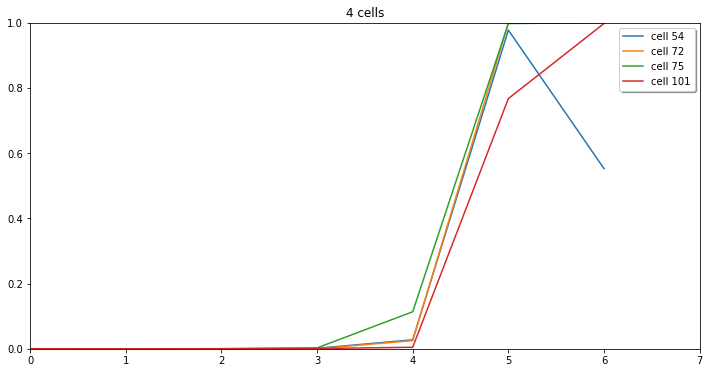

-----------------------------
group 10: [0.09295815 0.37740603 0.26022264 0.05701315 0.1078068  0.5189612
 0.9134389 ]
cells: [7, 95, 103]


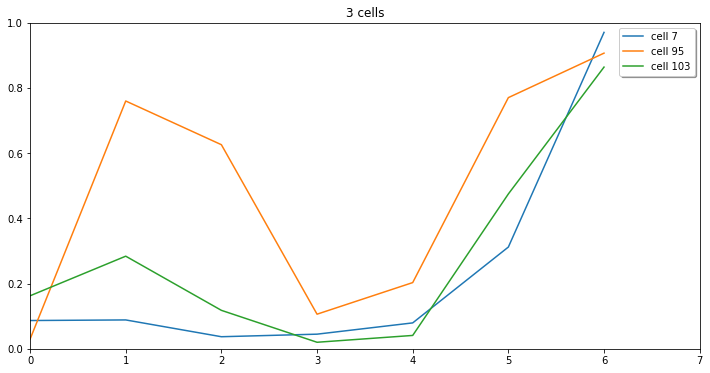

-----------------------------
group 11: [0.07167393 0.08609241 0.11066008 0.09900075 0.09125096 0.36741287
 0.26378912]
cells: [66, 76, 108, 122]


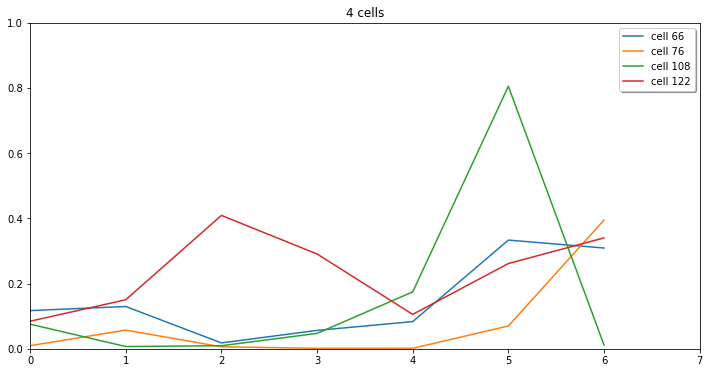

-----------------------------
group 12: [0.9769797  0.9713577  0.23398834 0.07454079 0.03050131 0.23360533
 0.3176337 ]
cells: [84, 87]


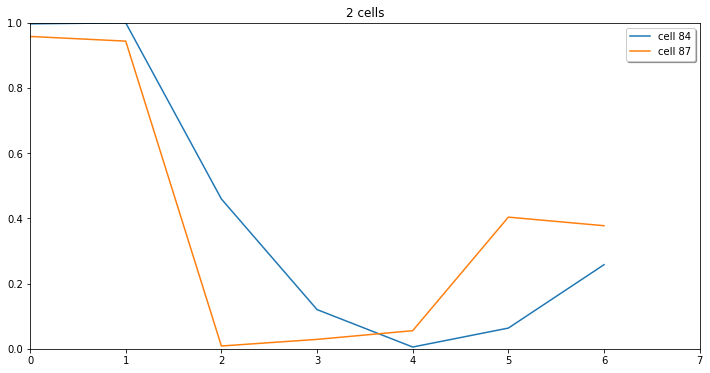

-----------------------------
group 13: [0.6968315  0.47383848 0.8201509  0.05825132 0.22532666 0.90315145
 0.832374  ]
cells: [2, 51, 118]


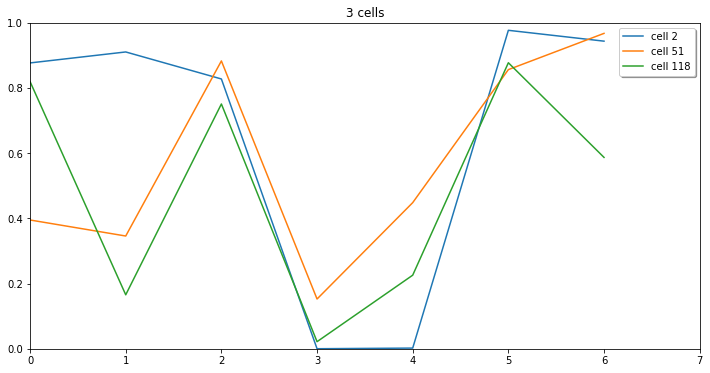

-----------------------------
group 14: [9.9997395e-01 9.9943018e-01 9.9645531e-01 9.7898757e-01 2.0383096e-01
 5.8733821e-03 1.9752979e-04]
cells: [40]


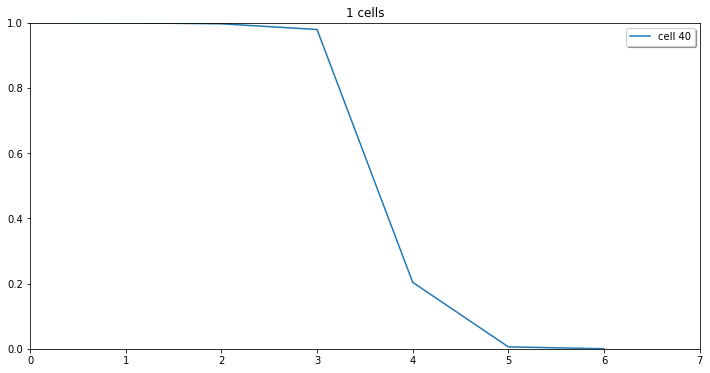

In [43]:
Cell.analyze(gates_avg['reset'], 15)

average of squared distances of samples to centers: 0.6462074242230696
average of squared distances of centers to centers: 7.94013671875
ratio: 12.287287983879738
-----------------------------
group 0: [ 0.8210677   0.9843614   0.99685925  0.99959993  0.99900174  0.88466203
 -0.72864074]
cells: [8, 42, 46, 50, 58, 59, 125]


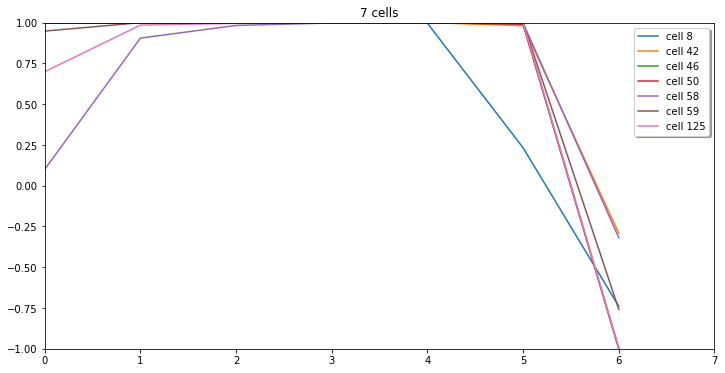

-----------------------------
group 1: [0.8565892  0.9609287  0.9286141  0.97250473 0.99504685 0.9758803
 0.3360692 ]
cells: [4, 5, 6, 21, 36, 39, 52, 53, 57, 62, 73, 90, 121]


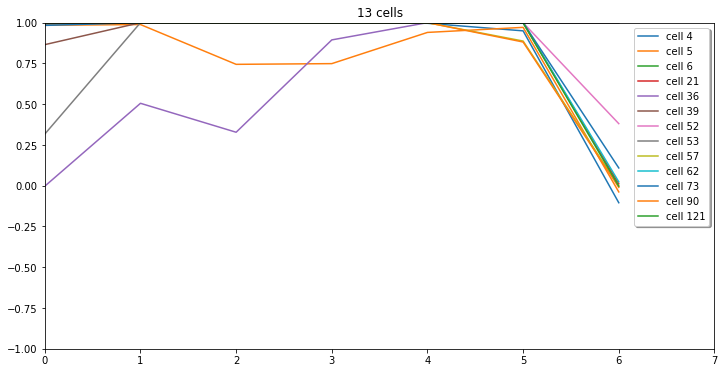

-----------------------------
group 2: [ 0.9292338   0.9999924   0.999814    0.9974278   0.85640585 -0.8624899
 -0.33065498]
cells: [11, 14, 33, 63, 67, 68, 77, 88, 113, 124]


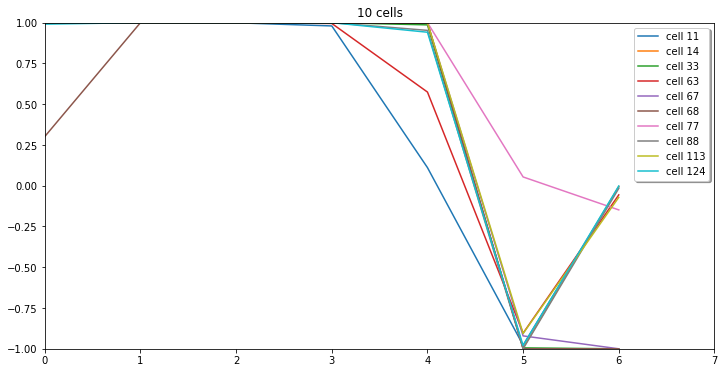

-----------------------------
group 3: [ 0.726046    0.9705136   0.90238565  0.5472303  -0.8096181  -0.98516095
 -0.8283915 ]
cells: [10, 43, 60, 78, 91, 95, 114]


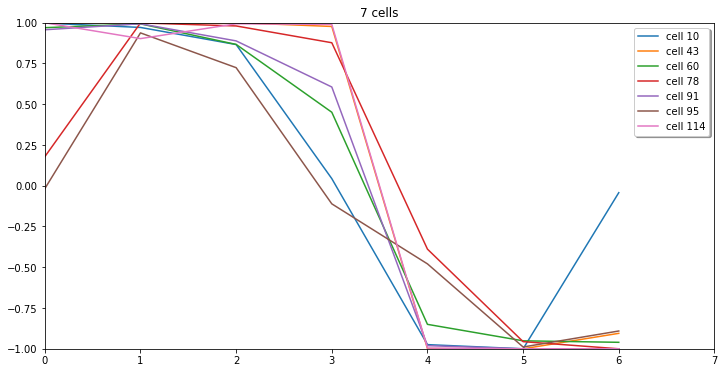

-----------------------------
group 4: [-0.00197986  0.01880118  0.06815923  0.05854143 -0.27581227 -0.910385
 -0.929248  ]
cells: [54, 55, 66, 72, 86, 94, 104, 107]


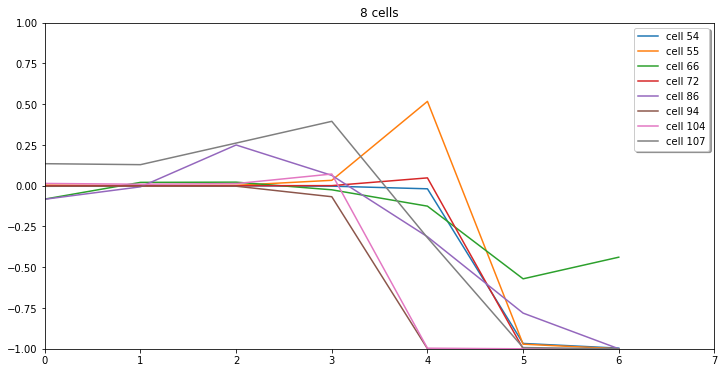

-----------------------------
group 5: [ 0.31136107 -0.50263095 -0.77181643 -0.9066133  -0.9651214  -0.9544154
 -0.60584587]
cells: [3, 89, 93, 110, 116, 117, 126]


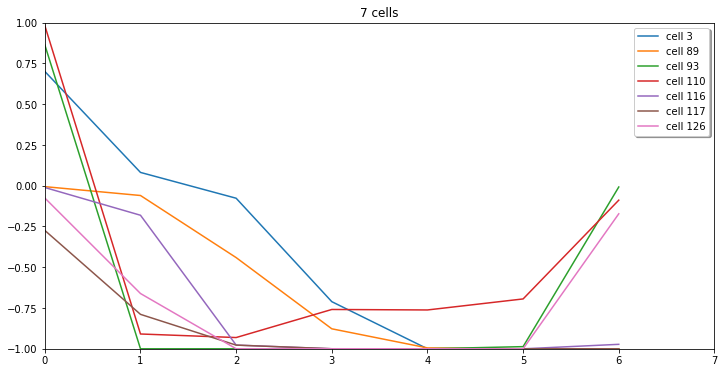

-----------------------------
group 6: [-0.9873162  -0.9883164  -0.91631734 -0.9858601  -0.97334194 -0.9384833
  0.12072701]
cells: [18, 19, 25, 26, 27, 30, 34, 35, 37, 45, 47, 48, 64, 65, 74, 81, 83, 99, 100, 109, 111, 115, 119, 120]


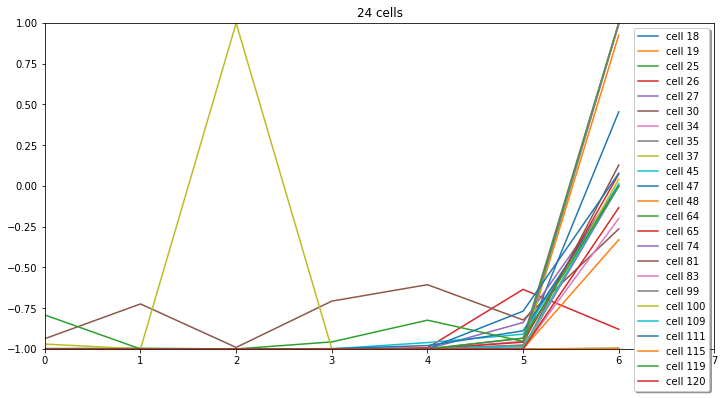

-----------------------------
group 7: [-0.7746188  -0.9561224  -0.9427583  -0.97725785 -0.8772245   0.9708573
  0.5185688 ]
cells: [0, 13, 20, 22, 28, 31, 41, 56, 82, 85, 92, 97, 102, 123]


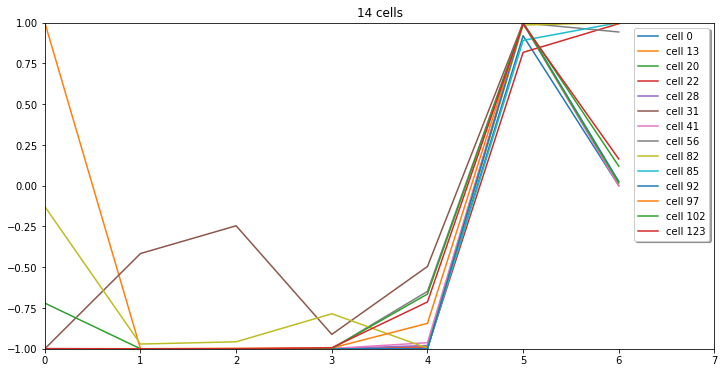

-----------------------------
group 8: [-0.8444662  -0.8782096  -0.70166516 -0.45986766  0.19183455  0.6900836
 -0.13575833]
cells: [17, 49, 51, 79, 87, 106]


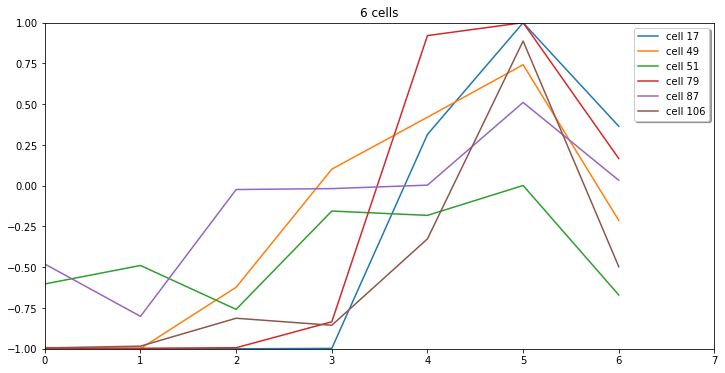

-----------------------------
group 9: [ 0.02320134 -0.1859136  -0.16973427 -0.11991845  0.05082372  0.8386568
  0.8265013 ]
cells: [7, 16, 23, 24, 61, 70, 71, 75, 76, 98, 103, 105, 108]


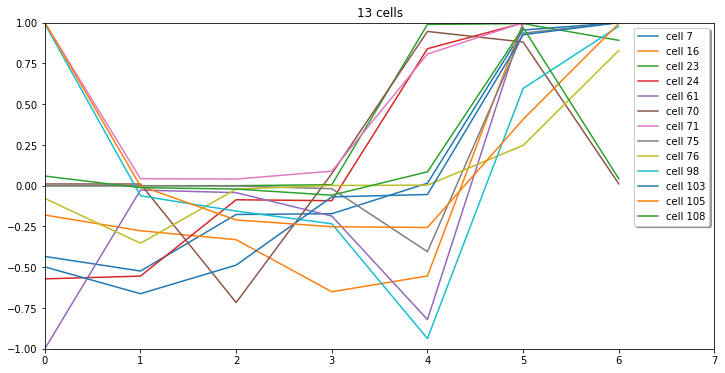

-----------------------------
group 10: [-0.6571764   0.33532467  0.77831304  0.350832    0.02165215  0.03523679
  0.36619058]
cells: [40, 96, 118, 122]


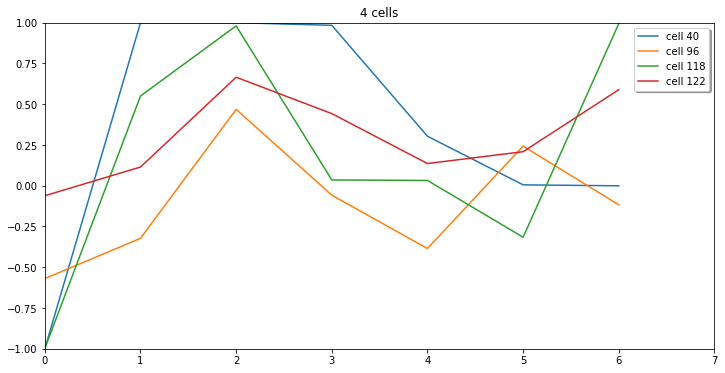

-----------------------------
group 11: [-0.84816074 -0.99912345  0.9117714   0.9725559   0.8178206  -0.04634159
 -0.23202679]
cells: [12, 38, 127]


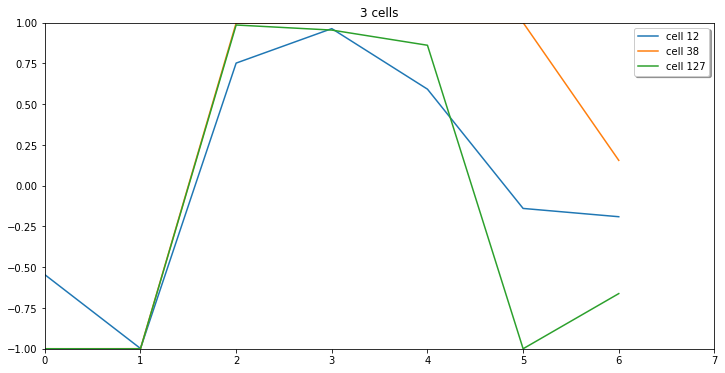

-----------------------------
group 12: [ 0.6613946  -0.21284999  0.35682938  0.00437738  0.03764468  0.77118605
 -0.99999   ]
cells: [2, 32, 101]


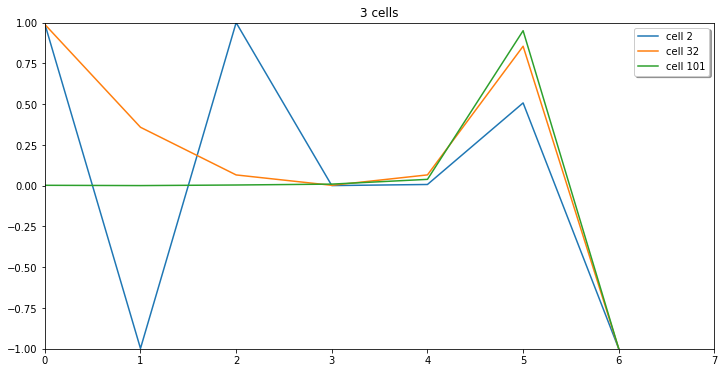

-----------------------------
group 13: [ 0.0918405   0.20865247 -0.34572828 -0.4004479  -0.37850097 -0.7267192
  0.6453146 ]
cells: [1, 9, 15, 69, 80]


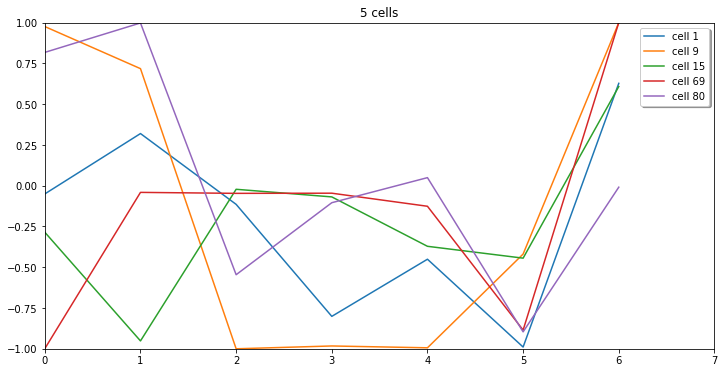

-----------------------------
group 14: [-0.883443    0.9534024  -0.98547393 -0.89855593 -0.7250318  -0.37274635
 -0.00634715]
cells: [29, 44, 84, 112]


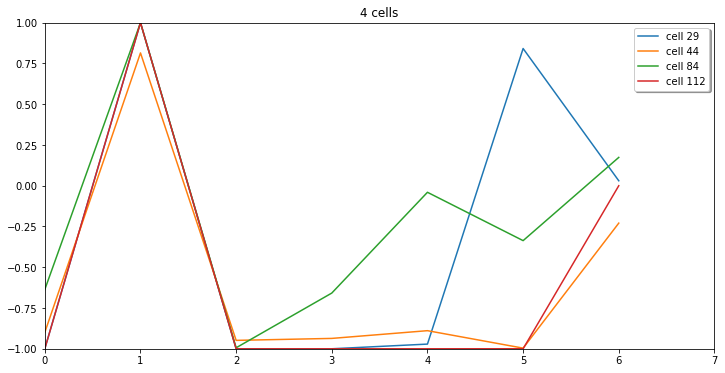

In [44]:
Cell.analyze(gates_avg['new'], 15, ylim=(-1,1))

average of squared distances of samples to centers: 0.7359838937206341
average of squared distances of centers to centers: 7.807069614955357
ratio: 10.607663675203709
-----------------------------
group 0: [-0.99909335 -0.9984791  -0.998031   -0.99685335 -0.90082383  0.8408672
  0.55259347]
cells: [0, 7, 17, 20, 22, 41, 56, 82, 85, 92]


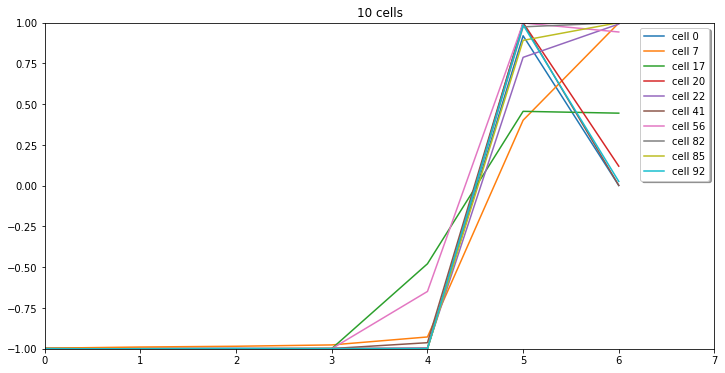

-----------------------------
group 1: [-0.7494613   0.13541314 -0.3532555  -0.6798668  -0.81597567  0.95826286
  0.7575678 ]
cells: [28, 29, 31, 61]


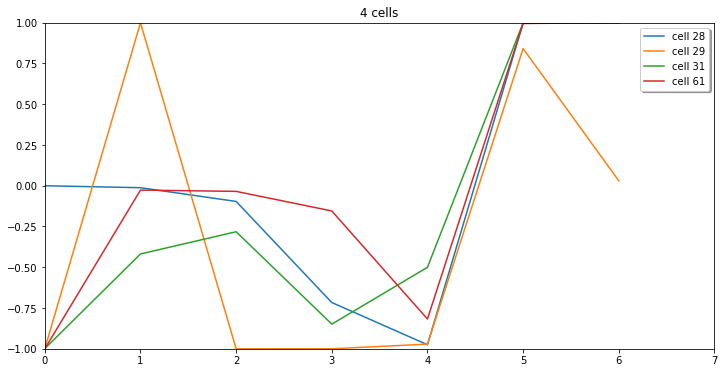

-----------------------------
group 2: [ 0.20975147  0.00589446 -0.01861682 -0.03656766  0.07192986  0.5261235
  0.3831299 ]
cells: [1, 4, 23, 24, 30, 36, 51, 57, 62, 71, 75, 76, 77, 96, 97, 104, 105, 108, 123]


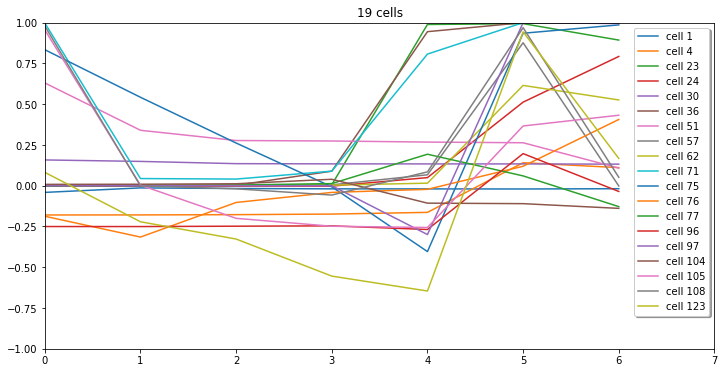

-----------------------------
group 3: [ 0.01164192 -0.23351741  0.1643005   0.14192396  0.26899073  0.72136307
 -0.9484908 ]
cells: [2, 32, 46, 50, 95, 101, 125]


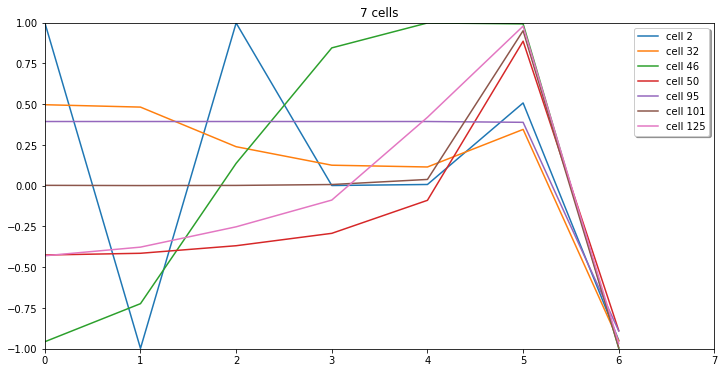

-----------------------------
group 4: [-0.10780318 -0.15895306  0.04204588  0.11825058 -0.01647201 -0.98335683
 -0.9825169 ]
cells: [25, 33, 54, 55, 67, 68, 72, 89, 94, 107, 117, 127]


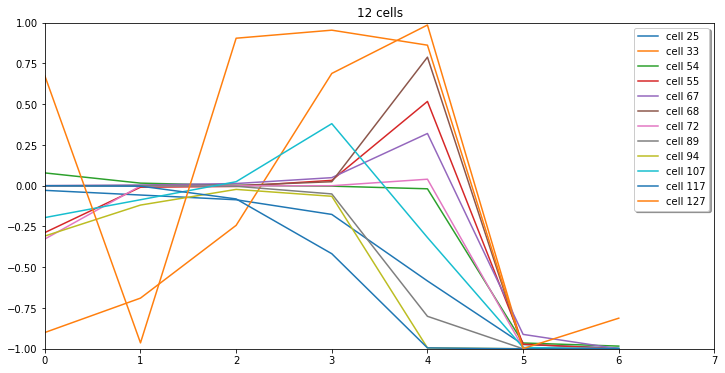

-----------------------------
group 5: [ 0.88153666  0.667288    0.5654828   0.3536138  -0.4238807  -0.8956297
 -0.60842013]
cells: [3, 60, 74, 83, 91, 98, 110, 114, 116, 126]


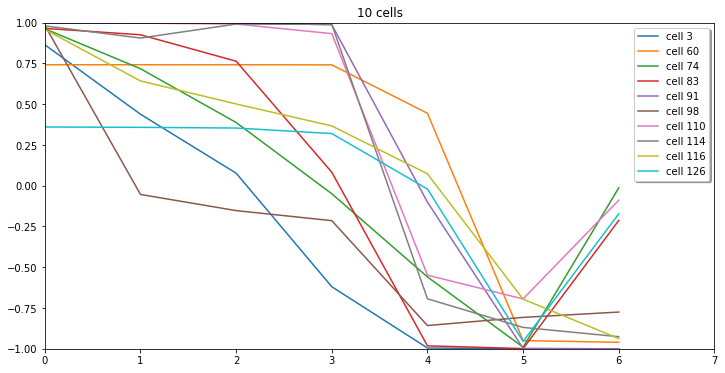

-----------------------------
group 6: [ 0.5903672   0.98204595  0.98308194  0.9810958   0.78361166 -0.92244834
  0.03825635]
cells: [11, 14, 18, 63, 88, 113, 124]


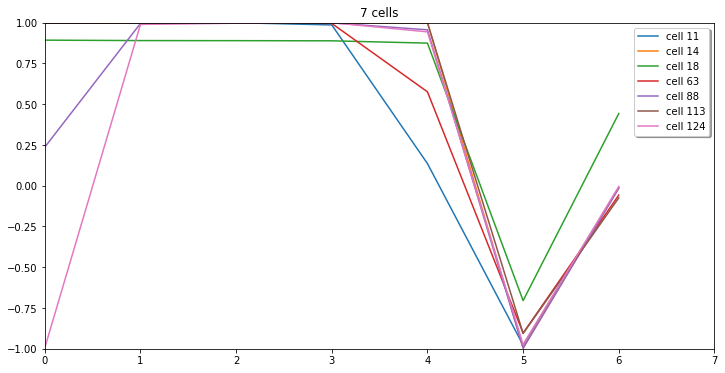

-----------------------------
group 7: [0.9017226  0.8954167  0.8886187  0.8841778  0.8728162  0.7885524
 0.09079446]
cells: [8, 16, 43, 44, 52, 66, 70, 78, 87, 90, 106, 121]


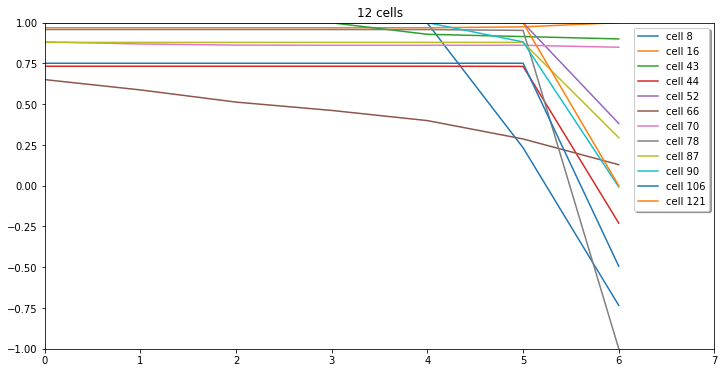

-----------------------------
group 8: [-0.99400926  0.99375826  0.9966364   0.99281716  0.76757956  0.662375
 -0.089772  ]
cells: [21, 40, 42]


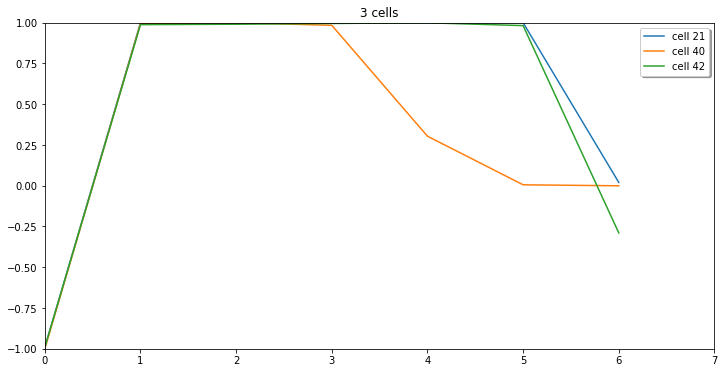

-----------------------------
group 9: [-0.8498356  -0.8417961  -0.5041271   0.26232198  0.74212956  0.7796085
  0.28355175]
cells: [5, 6, 12, 38, 39, 53, 59, 73, 79]


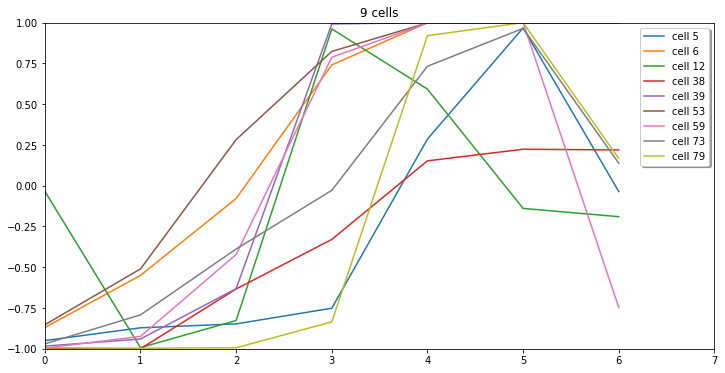

-----------------------------
group 10: [-0.43987393 -0.09292477  0.15340242 -0.1458533  -0.2849127  -0.7653901
  0.4828253 ]
cells: [10, 15, 19, 45, 69, 100, 118]


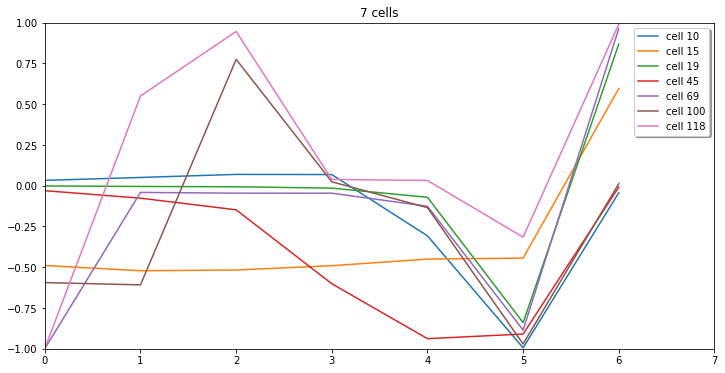

-----------------------------
group 11: [-0.9350271  -0.8464467  -0.9253317  -0.9314923  -0.90232694 -0.86170864
  0.04838647]
cells: [9, 26, 27, 34, 35, 37, 47, 48, 49, 58, 65, 80, 81, 86, 99, 103, 109, 111, 112, 115, 119, 122]


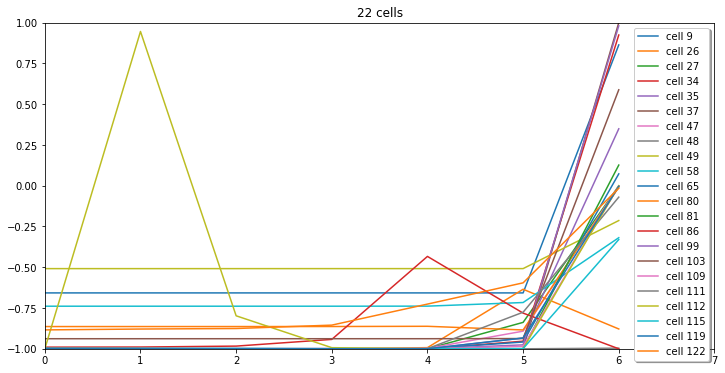

-----------------------------
group 12: [ 0.9892624  -0.9962588  -0.9975522  -0.99840987 -0.9995165  -0.9931939
 -0.13299468]
cells: [93, 120]


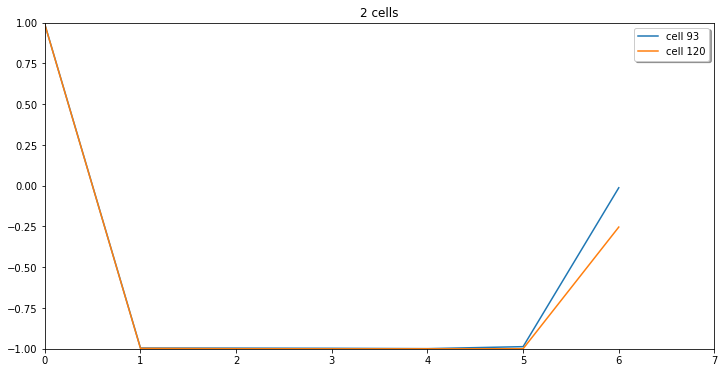

-----------------------------
group 13: [ 0.9955831  -0.99884385 -0.9997784  -0.99916923 -0.82464194  0.9979591
  0.00974217]
cells: [13, 102]


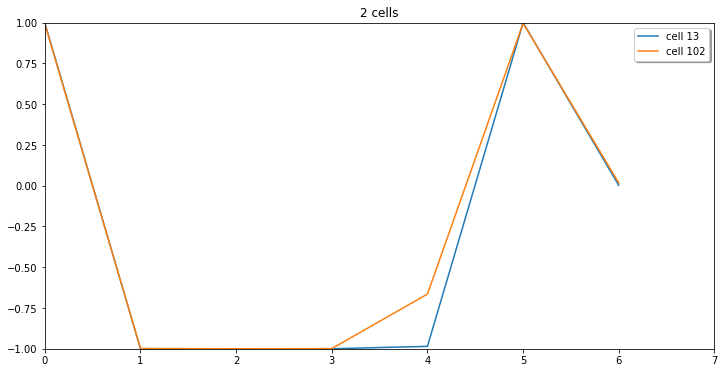

-----------------------------
group 14: [ 0.9924415   0.9961174  -0.99649656 -0.8139875  -0.4364517  -0.6391266
  0.35079116]
cells: [64, 84]


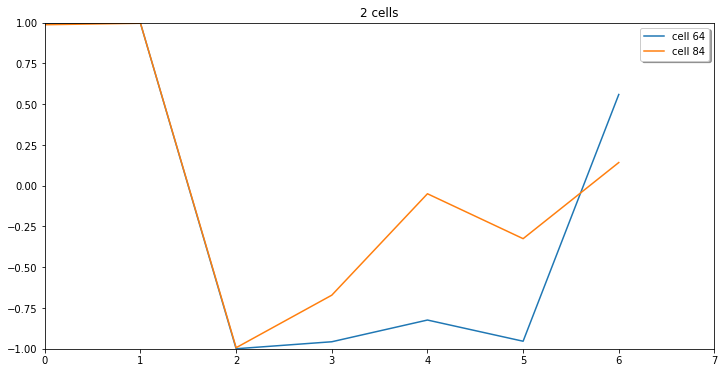

In [45]:
Cell.analyze(gates_avg['hidden'], 15, ylim=(-1,1))

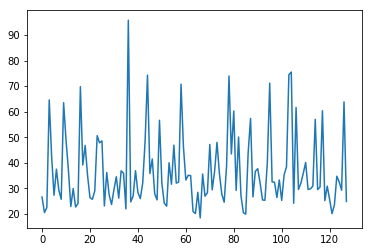

In [46]:
a = np.sum(np.abs(W), axis=0)
plt.plot(a)

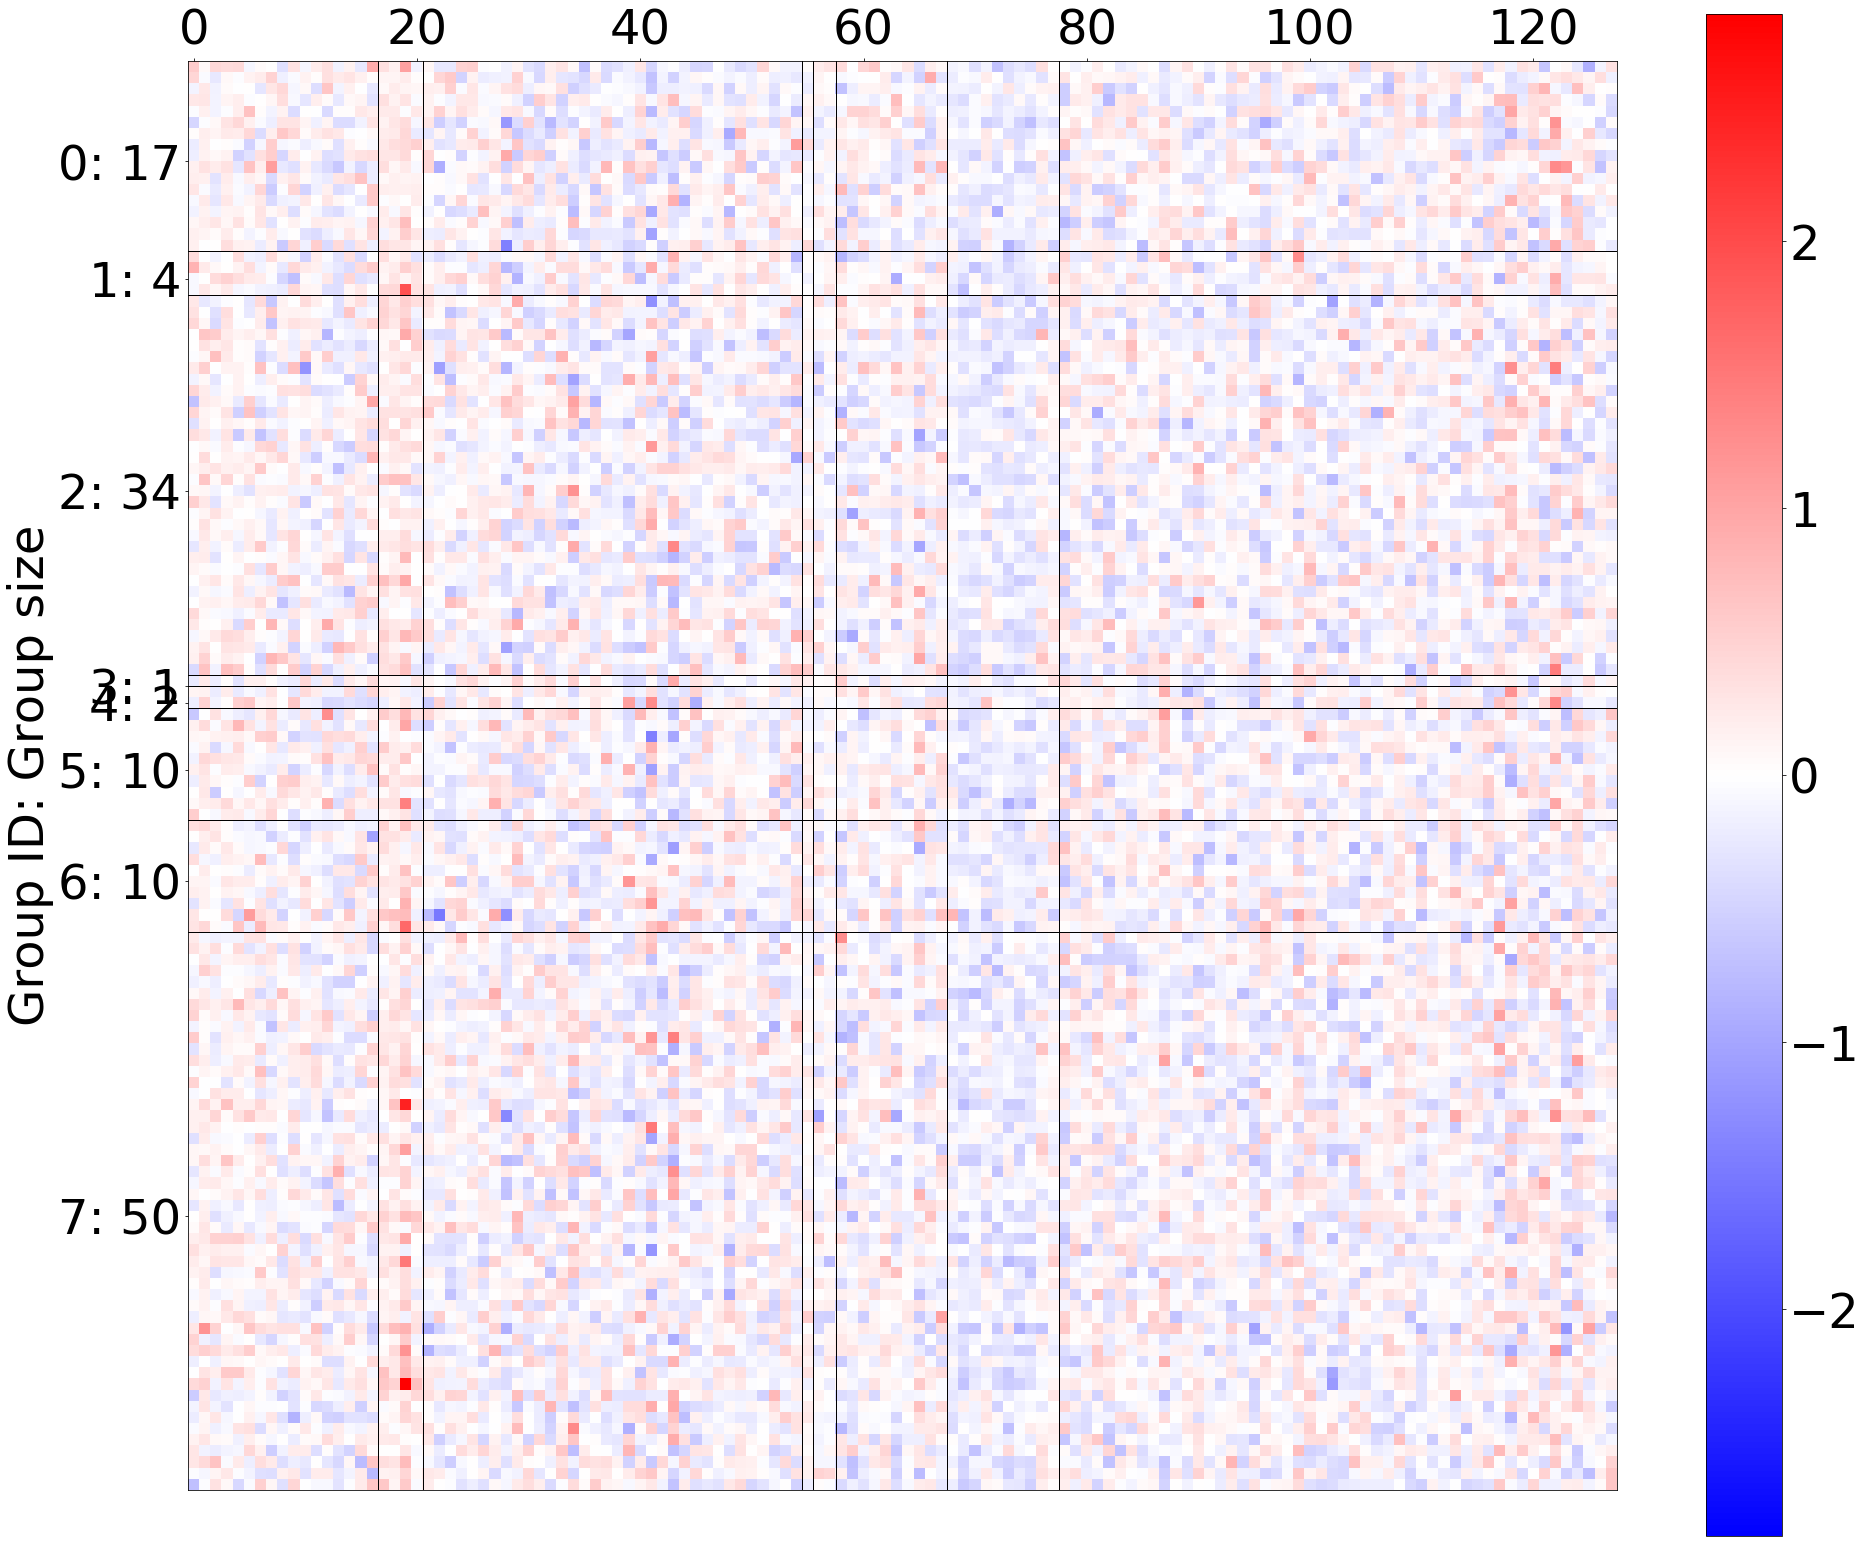

In [47]:
W = model.decoder.clf.weight.detach().numpy()
Cell.plot_weights(W[512:640,:], groups)

In [48]:
clf_weight = model.decoder.clf.weight.detach().numpy()

In [49]:
U, S, V = np.linalg.svd(clf_weight, full_matrices=False)
# clf_weight = W @ R
W = U @ np.diag(S) # (6618, 128)
R = V #(128, 128)

In [50]:
S

array([428.79904  , 125.86876  ,  90.76498  ,  51.45735  ,  35.853115 ,
        34.39052  ,  32.615383 ,  29.836561 ,  29.82     ,  29.37431  ,
        28.432539 ,  27.979502 ,  27.347183 ,  26.872574 ,  26.81113  ,
        26.354921 ,  26.000113 ,  25.777252 ,  25.503975 ,  25.463854 ,
        24.72661  ,  24.549894 ,  24.375895 ,  24.114586 ,  23.98704  ,
        23.724323 ,  23.270113 ,  22.960634 ,  22.844603 ,  22.530994 ,
        22.204483 ,  21.908573 ,  21.731592 ,  21.403759 ,  21.207222 ,
        20.956482 ,  20.921534 ,  20.690437 ,  20.605423 ,  20.452322 ,
        20.163202 ,  20.085281 ,  19.959707 ,  19.808819 ,  19.684172 ,
        19.477629 ,  19.376627 ,  19.331516 ,  19.067013 ,  18.935553 ,
        18.813414 ,  18.720522 ,  18.552177 ,  18.29803  ,  18.270006 ,
        18.1028   ,  18.062773 ,  17.942133 ,  17.852936 ,  17.776838 ,
        17.724602 ,  17.526083 ,  17.49     ,  17.369001 ,  17.326803 ,
        17.249512 ,  17.181849 ,  17.061434 ,  17.004745 ,  16.8

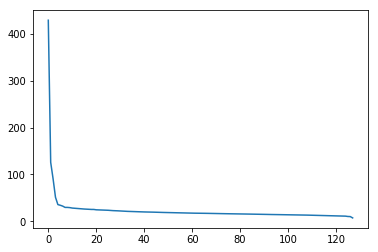

In [51]:
plt.plot(S)

In [52]:
def plot_weights(W, groups=None, perm_dim = (True, True)):
    # concatenate groups and reorder cells
    if groups:
        indices = []
        seps = [] # separations
        ticks, labels = [], []
        accu = 0
        for g, group in enumerate(groups):
            indices += group
            accu += len(group)
            seps.append(accu)
            ticks.append(accu-len(group)/2)
            labels.append(f'{g}: {len(group)}')
        seps = seps[:-1]
        if perm_dim[0]:
            W = W[indices,:]
        if perm_dim[1]:
            W = W[:,indices]
        
    # plot
    fig, ax = plt.subplots(figsize=(32,28))
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    vmax = np.max(np.abs(W))
    plt.imshow(W, cmap='bwr', vmax=vmax, vmin=-vmax)
    plt.colorbar().ax.tick_params(labelsize=48)
    
    # add separation lines
    if groups:
        for sep in seps:
            if perm_dim[0]:
                plt.axhline(y=sep-0.5, color='black', linewidth=1.0)
            if perm_dim[1]:
                plt.axvline(x=sep-0.5, color='black', linewidth=1.0)
        plt.xticks(fontsize=48)
        plt.yticks(fontsize=48)
        if perm_dim[0]:
            plt.yticks(ticks, labels)
            plt.ylabel('Group ID: Group size', fontsize=48)
    
    plt.savefig('weight_.png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.show()

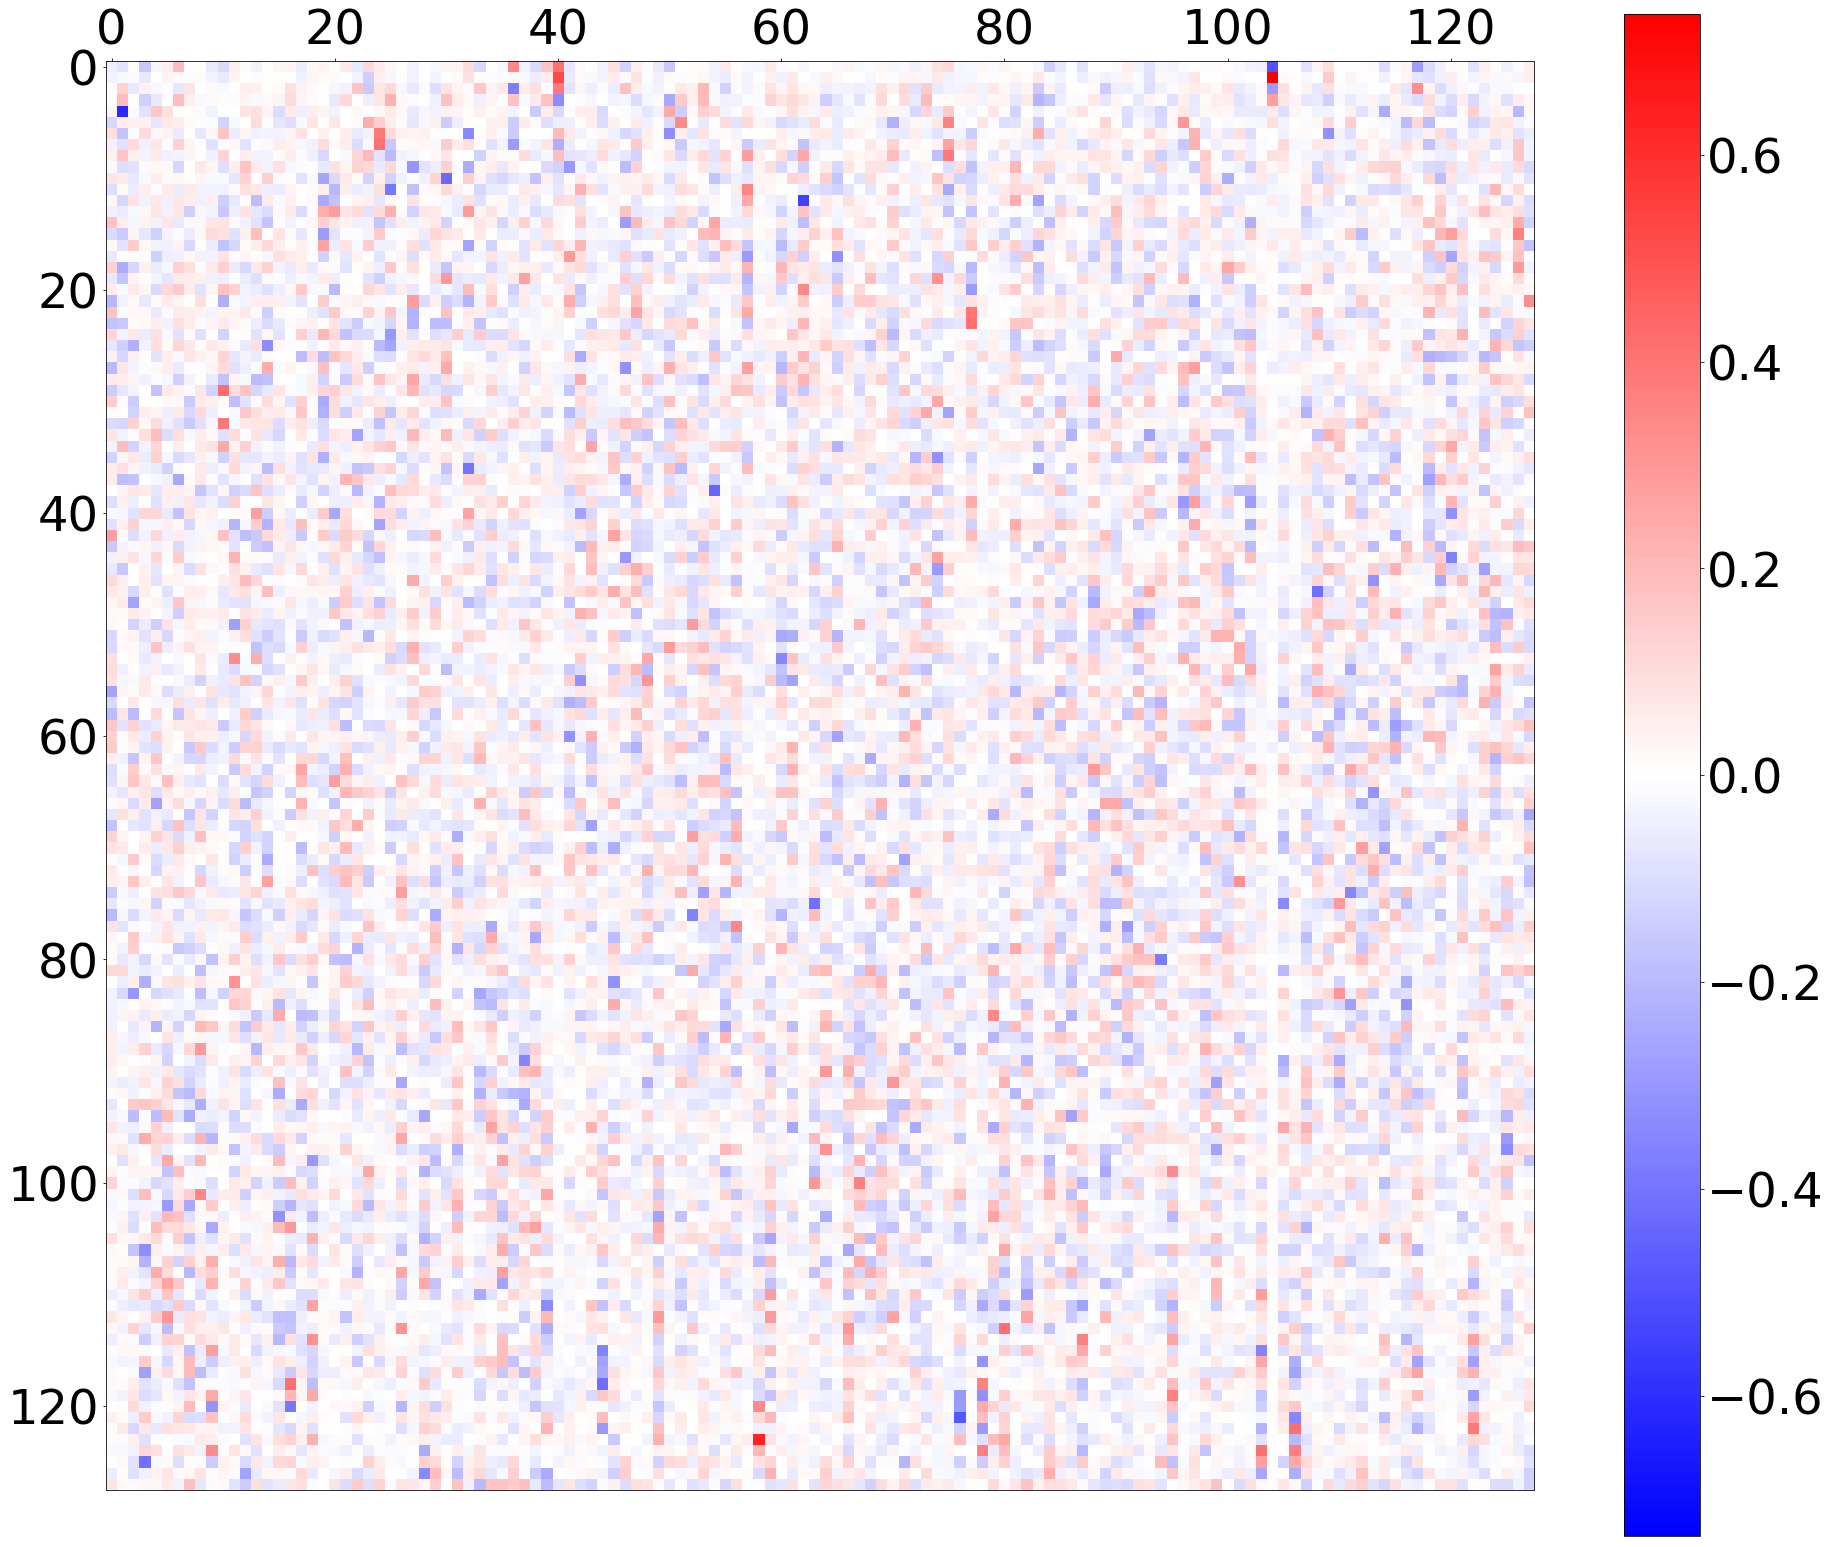

In [53]:
Cell.plot_weights(R, groups=groups, perm_dim=(0,0))

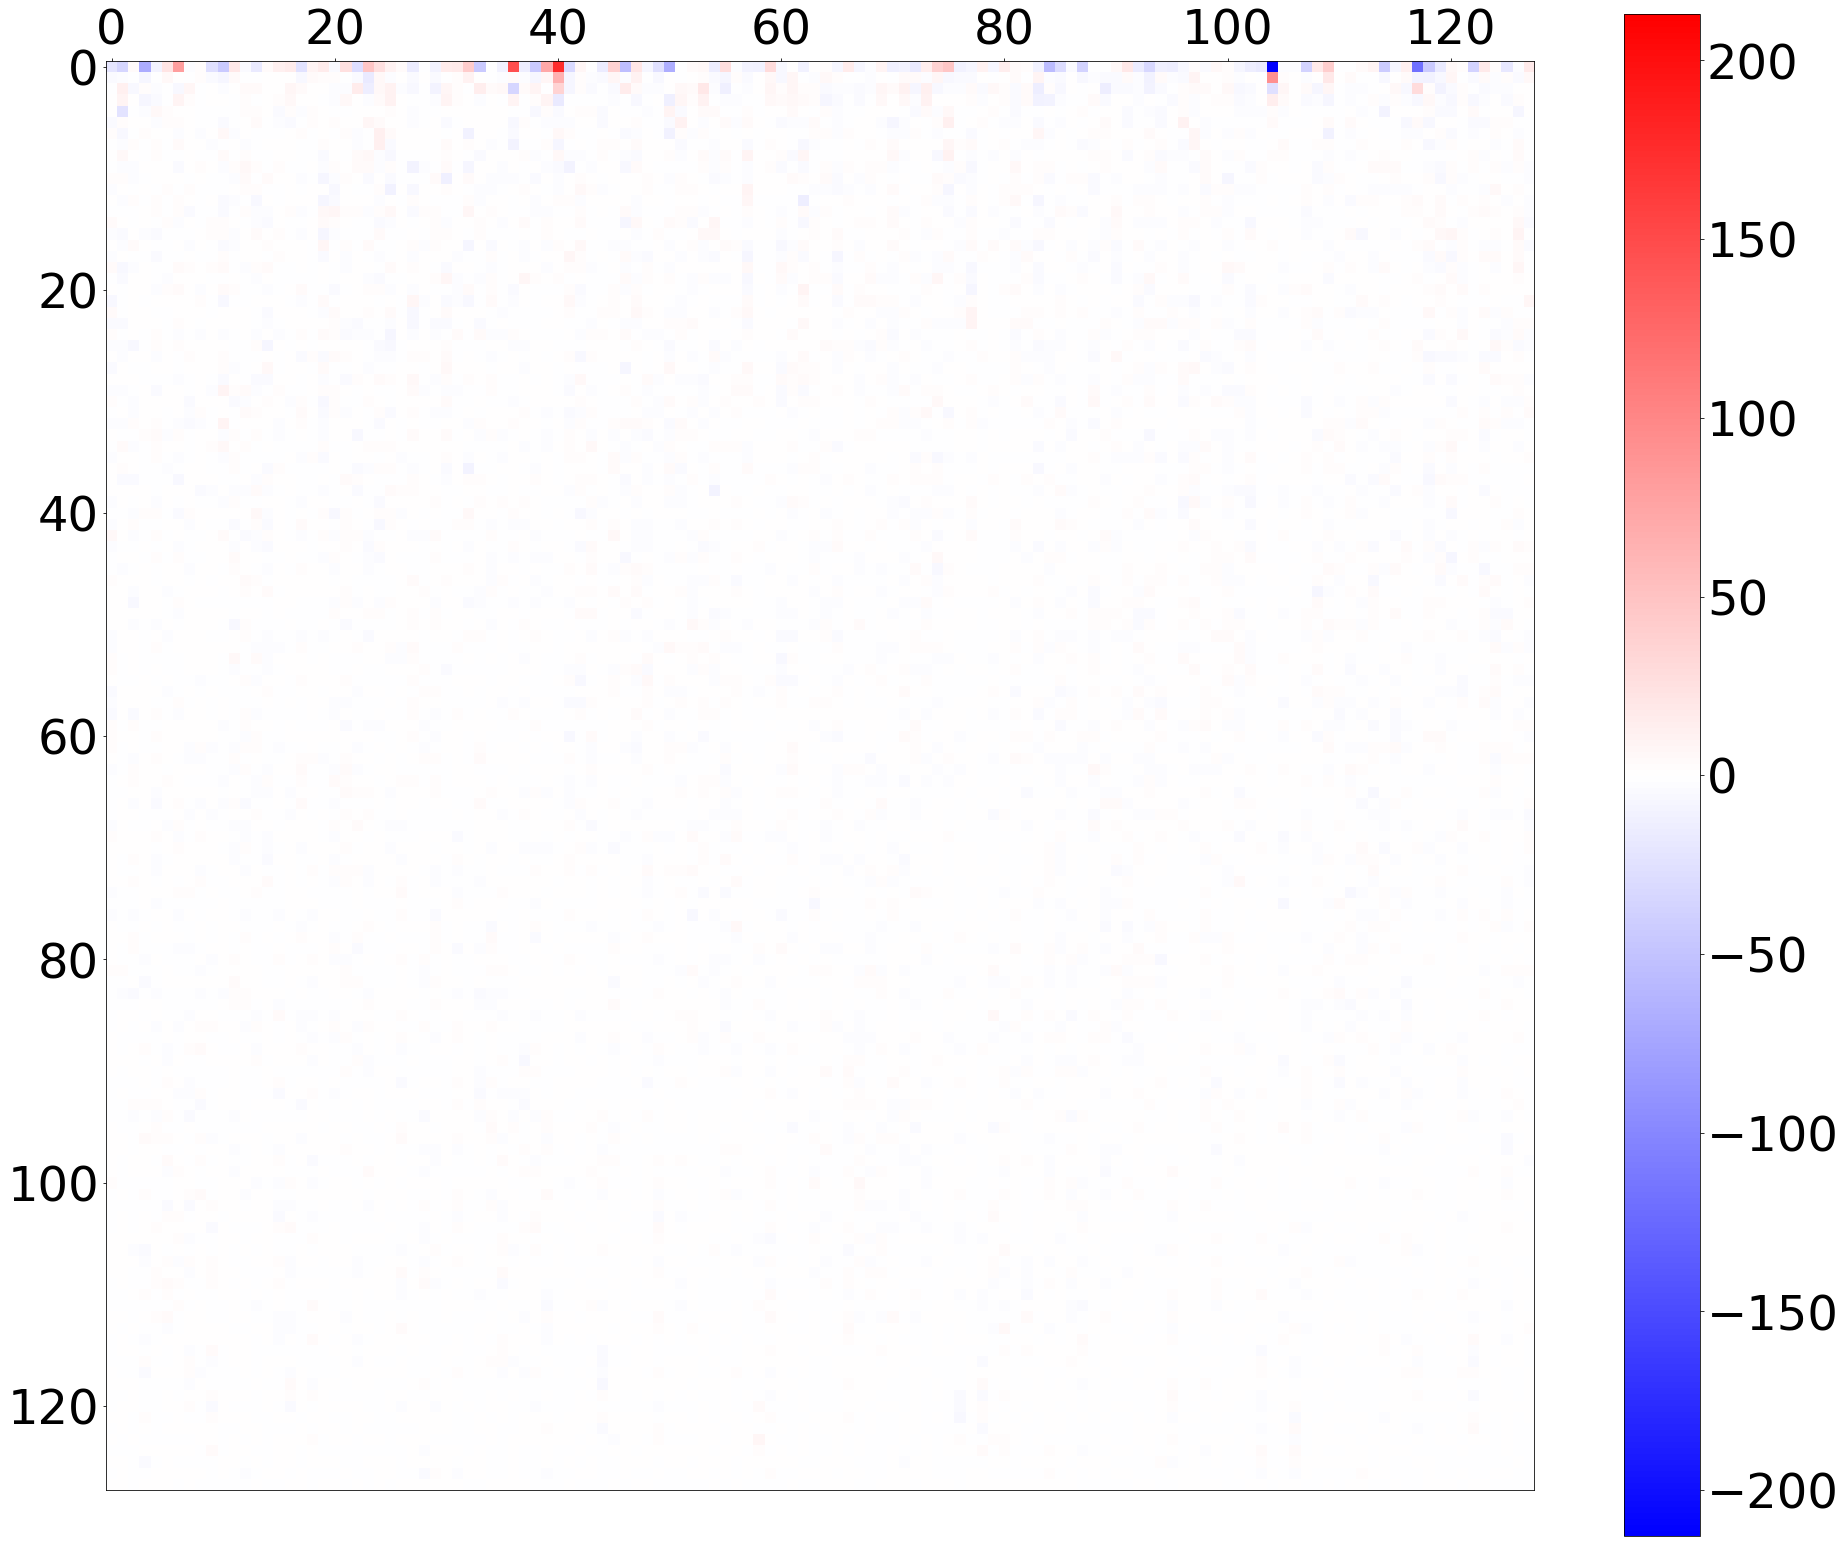

In [54]:
Cell.plot_weights(np.diag(S)@R, groups=groups, perm_dim=(0,0))

In [55]:
components = np.sum(np.abs((np.diag(S) @ R)[:3,:]), axis=0)
sorted(enumerate(components), key=lambda c: c[1], reverse=True)

[(104, 331.576),
 (40, 276.90515),
 (36, 184.18234),
 (117, 158.34967),
 (6, 88.509155),
 (39, 80.48997),
 (3, 79.149254),
 (23, 78.07395),
 (46, 72.0407),
 (50, 69.86562),
 (109, 68.459435),
 (38, 59.890766),
 (33, 59.745285),
 (84, 59.491375),
 (118, 58.040703),
 (32, 55.000984),
 (75, 54.987827),
 (10, 54.30334),
 (93, 52.10797),
 (74, 52.05805),
 (45, 49.430065),
 (114, 47.738926),
 (1, 47.728954),
 (22, 47.685688),
 (55, 45.971863),
 (41, 45.03758),
 (107, 42.459156),
 (87, 41.83479),
 (59, 41.249596),
 (122, 40.15092),
 (24, 38.916645),
 (85, 38.728043),
 (47, 35.94053),
 (49, 33.965656),
 (83, 32.705612),
 (119, 32.66163),
 (17, 32.42913),
 (9, 30.969515),
 (73, 29.795803),
 (21, 29.449976),
 (72, 29.315947),
 (53, 28.296616),
 (5, 28.288849),
 (91, 28.177238),
 (123, 27.240574),
 (27, 26.154078),
 (0, 26.081915),
 (25, 24.662502),
 (30, 24.447575),
 (11, 24.43904),
 (16, 24.282219),
 (108, 24.25102),
 (127, 23.702368),
 (71, 23.316105),
 (116, 23.198002),
 (125, 22.885632),
 (3